In [1]:
# This file is modified version of original:
# https://www.kaggle.com/code/baurzhanurazalinov/parkinson-s-freezing-submission-code

**Imports**

In [2]:
'''
The submission code consists of 3 parts: 
1) Tdcsfog. Here we define the tdcsfog model, then load tdcsfog test data and predict targets.
2) Defog. Here we define the defog model, then load defog test data and predict targets.
3) Submission. Here the predicted values are collected, uniformly averaged (if several models were used), then the submission.csv is created.

Tdcsfog model and defog model differ in parameters and pretrained weights.

Model whose last denselayer has 3 nodes corresponds to tdcsfog.
Model whose last denselayer has 4 nodes corresponds to defog.

'''

import os 
import math

import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from joblib import Parallel, delayed

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

**Load**

In [3]:
all_submissions = [] # All predicted values are put here

tsfog_ids = [fname.split('.')[0] for fname in os.listdir('/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/test/tdcsfog')] # Get tdcsfog ids from test directory
defog_ids = [fname.split('.')[0] for fname in os.listdir('/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/test/defog')] # Get defog ids from test directory

################################################################################################################

### Part 1. TDCSFOG

################################################################################################################

**Configuration**

In [4]:
# CFG = {'TPU': 0,
#        'block_size': 15552, 
#        'block_stride': 15552//16,
#        'patch_size': 18, 
       
#        'fog_model_dim': 320,
#        'fog_model_num_heads': 6,
#        'fog_model_num_encoder_layers': 5,
#        'fog_model_num_lstm_layers': 2,
#        'fog_model_first_dropout': 0.1,
#        'fog_model_encoder_dropout': 0.1,
#        'fog_model_mha_dropout': 0.0,
#       }

# assert CFG['block_size'] % CFG['patch_size'] == 0
# assert CFG['block_size'] % CFG['block_stride'] == 0

# '''
# Mean-std normalization function. 
# Example input: shape (5000), dtype np.float32
# Example output: shape (5000), dtype np.float32

# Used to normalize AccV, AccML, AccAP values.

# '''

# def sample_normalize(sample):
#     mean = tf.math.reduce_mean(sample)
#     std = tf.math.reduce_std(sample)
#     sample = tf.math.divide_no_nan(sample-mean, std)
    
#     return sample.numpy()

# '''
# Function for splitting a series into blocks. Blocks can overlap. 
# How the function works:
# Suppose we have a series with AccV, AccML, AccAP columns and len of 50000, that is (50000, 3). 
# First, the series is padded so that the final length is divisible by CFG['block_size'] = 15552. Now the series shape is (62208, 3).
# Then we get blocks: first block is series[0:15552, :], second block is series[972:16524, :], ... , last block is series[46656:62208, :].

# '''

# def get_blocks(series, columns):
#     series = series.copy()
#     series = series[columns]
#     series = series.values
#     series = series.astype(np.float32)
    
#     block_count = math.ceil(len(series) / CFG['block_size'])
    
#     series = np.pad(series, pad_width=[[0, block_count*CFG['block_size']-len(series)], [0, 0]])
    
#     block_begins = list(range(0, len(series), CFG['block_stride']))
#     block_begins = [x for x in block_begins if x+CFG['block_size'] <= len(series)]
    
#     blocks = []
#     for begin in block_begins:
#         values = series[begin:begin+CFG['block_size']]
#         blocks.append({'begin': begin,
#                        'end': begin+CFG['block_size'],
#                        'values': values})
    
#     return blocks

# '''
# Train and inference batch size

# '''

# GPU_BATCH_SIZE = 4
# TPU_BATCH_SIZE = GPU_BATCH_SIZE*8

# '''
# The transformer encoder layer
# For more details, see https://arxiv.org/pdf/1706.03762.pdf [Attention Is All You Need]

# '''

# class EncoderLayer(tf.keras.layers.Layer):
#     def __init__(self):
#         super().__init__()
        
#         self.mha = tf.keras.layers.MultiHeadAttention(num_heads=CFG['fog_model_num_heads'], key_dim=CFG['fog_model_dim'], dropout=CFG['fog_model_mha_dropout'])
        
#         self.add = tf.keras.layers.Add()
        
#         self.layernorm = tf.keras.layers.LayerNormalization()
        
#         self.seq = tf.keras.Sequential([tf.keras.layers.Dense(CFG['fog_model_dim'], activation='relu'), 
#                                         tf.keras.layers.Dropout(CFG['fog_model_encoder_dropout']), 
#                                         tf.keras.layers.Dense(CFG['fog_model_dim']), 
#                                         tf.keras.layers.Dropout(CFG['fog_model_encoder_dropout']),
#                                        ])
        
#     def call(self, x):
#         attn_output = self.mha(query=x, key=x, value=x)
#         x = self.add([x, attn_output])
#         x = self.layernorm(x)
#         x = self.add([x, self.seq(x)])
#         x = self.layernorm(x)
        
#         return x
    
# '''
# FOGEncoder is a combination of transformer encoder (D=320, H=6, L=5) and two BidirectionalLSTM layers

# '''

# class FOGEncoder(tf.keras.Model):
#     def __init__(self):
#         super().__init__()
        
#         self.first_linear = tf.keras.layers.Dense(CFG['fog_model_dim'])
        
#         self.add = tf.keras.layers.Add()
        
#         self.first_dropout = tf.keras.layers.Dropout(CFG['fog_model_first_dropout'])
        
#         self.enc_layers = [EncoderLayer() for _ in range(CFG['fog_model_num_encoder_layers'])]
        
#         self.lstm_layers = [tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(CFG['fog_model_dim'], return_sequences=True)) for _ in range(CFG['fog_model_num_lstm_layers'])]
        
#         self.sequence_len = CFG['block_size'] // CFG['patch_size']
#         self.pos_encoding = tf.Variable(initial_value=tf.random.normal(shape=(1, self.sequence_len, CFG['fog_model_dim']), stddev=0.02), trainable=True)
        
#     def call(self, x, training=None): # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3), Example shape (4, 864, 54)
#         x = x / 25.0 # Normalization attempt in the segment [-1, 1]
#         x = self.first_linear(x) # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['fog_model_dim']), Example shape (4, 864, 320)
          
#         if training: # augmentation by randomly roll of the position encoding tensor
#             random_pos_encoding = tf.roll(tf.tile(self.pos_encoding, multiples=[GPU_BATCH_SIZE, 1, 1]), 
#                                           shift=tf.random.uniform(shape=(GPU_BATCH_SIZE,), minval=-self.sequence_len, maxval=0, dtype=tf.int32),
#                                           axis=GPU_BATCH_SIZE * [1],
#                                           )
#             x = self.add([x, random_pos_encoding])
        
#         else: # without augmentation 
#             x = self.add([x, tf.tile(self.pos_encoding, multiples=[GPU_BATCH_SIZE, 1, 1])])
            
#         x = self.first_dropout(x)
        
#         for i in range(CFG['fog_model_num_encoder_layers']): x = self.enc_layers[i](x) # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['fog_model_dim']), Example shape (4, 864, 320)
#         for i in range(CFG['fog_model_num_lstm_layers']): x = self.lstm_layers[i](x) # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['fog_model_dim']*2), Example shape (4, 864, 640)
            
#         return x
    
# class FOGModel(tf.keras.Model):
#     def __init__(self):
#         super().__init__()
        
#         self.encoder = FOGEncoder()
#         self.last_linear = tf.keras.layers.Dense(3) 
        
#     def call(self, x): # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3), Example shape (4, 864, 54)
#         x = self.encoder(x) # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['fog_model_dim']*2), Example shape (4, 864, 640)
#         x = self.last_linear(x) # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], 3), Example shape (4, 864, 3)
#         x = tf.nn.sigmoid(x) # Sigmoid activation
        
#         return x
    
# WEIGHTS = '/kaggle/input/parkinson-weights/parkinson_weights/044_0.609_0.911_0.0481_model.h5' # TDCSFOG weights
    
# model = FOGModel()
# model.build(input_shape=(GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3))
# if len(WEIGHTS): model.load_weights(WEIGHTS)

**Prediction**

In [5]:
# '''
# PredictionFnCallback is used for:
# 1. Loading test data
# 2. FOGModel data preparation
# 3. Prediction

# '''

# class PredictionFnCallback(tf.keras.callbacks.Callback):
    
#     def __init__(self, prediction_ids, model=None, verbose=0):
        
#         if not model is None: self.model = model
#         self.verbose = verbose
         
#         def init(Id, path):
#             series = pd.read_csv(path).reset_index(drop=True)
#             series['Id'] = Id
#             series['AccV'] = sample_normalize(series['AccV'].values)
#             series['AccML'] = sample_normalize(series['AccML'].values)
#             series['AccAP'] = sample_normalize(series['AccAP'].values)
            
#             series_blocks=[]
#             for block in get_blocks(series, ['AccV', 'AccML', 'AccAP']): # Example shape (15552, 3)
#                 values = tf.reshape(block['values'], shape=(CFG['block_size'] // CFG['patch_size'], CFG['patch_size'], 3)) # Example shape (864, 18, 3)
#                 values = tf.reshape(values, shape=(CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3)) # Example shape (864, 54)
#                 values = tf.expand_dims(values, axis=0) # Example shape (1, 864, 54)
                
#                 self.blocks.append(values)
#                 series_blocks.append((self.blocks_counter, block['begin'], block['end']))
#                 self.blocks_counter += 1
            
#             description = {}
#             description['series'] = series
#             description['series_blocks'] = series_blocks
#             self.descriptions.append(description)
            
#         self.descriptions = [] # Blocks metadata
#         self.blocks = [] # Test data blocks
#         self.blocks_counter=0 # Blocks counter
        
#         tsfog_ids = prediction_ids
#         tsfog_paths = [f'/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/test/tdcsfog/{tsfog_id}.csv' for tsfog_id in tsfog_ids]
#         for tsfog_id, tsfog_path in tqdm(zip(tsfog_ids, tsfog_paths), total=len(tsfog_ids), desc='PredictionFnCallback Initialization', disable=1-verbose): 
#             init(tsfog_id, tsfog_path)
            
#         self.blocks = tf.concat(self.blocks, axis=0) # Example shape (self.blocks_counter, 864, 54)
        
#         '''
#         self.blocks is padded so that the final length is divisible by inference batch size for error-free operation of model.predict function
#         Padded values have no effect on the predictions
        
#         '''
        
#         self.blocks = tf.pad(self.blocks, 
#                              paddings=[[0, math.ceil(self.blocks_counter / (TPU_BATCH_SIZE if CFG['TPU'] else GPU_BATCH_SIZE))*(TPU_BATCH_SIZE if CFG['TPU'] else GPU_BATCH_SIZE)-self.blocks_counter], 
#                                                     [0, 0], 
#                                                     [0, 0],
#                                       ]) # Example shape (self.blocks_counter+pad_value, 864, 54)
        
#         print(f'\n[EventPredictionFnCallback Initialization] [Series] {len(self.descriptions)} [Blocks] {self.blocks_counter}\n')
    
#     def prediction(self):
#         predictions = model.predict(self.blocks, batch_size=TPU_BATCH_SIZE if CFG['TPU'] else GPU_BATCH_SIZE, verbose=self.verbose) # Example shape (self.blocks_counter+pad_value, 864, 3)
#         predictions = tf.expand_dims(predictions, axis=-1) # Example shape (self.blocks_counter+pad_value, 864, 3, 1)
#         predictions = tf.transpose(predictions, perm=[0, 1, 3, 2]) # Example shape (self.blocks_counter+pad_value, 864, 1, 3)
#         predictions = tf.tile(predictions, multiples=[1, 1, CFG['patch_size'], 1]) # Example shape (self.blocks_counter+pad_value, 864, 18, 3)
#         predictions = tf.reshape(predictions, shape=(predictions.shape[0], predictions.shape[1]*predictions.shape[2], 3)) # Example shape (self.blocks_counter+pad_value, 15552, 3)
#         predictions = predictions.numpy()
        
#         '''
#         The following function aggregates predictions blocks and creates dataframes with StartHesitation_prediction, Turn_prediction, Walking_prediction columns.
        
#         '''
        
#         def create_target(description):
#             series, series_blocks = description['series'].copy(), description['series_blocks']
            
#             values = np.zeros((series_blocks[-1][2], 4))
#             for series_block in series_blocks:
#                 i, begin, end = series_block
#                 values[begin:end, 0:3] += predictions[i]
#                 values[begin:end, 3] += 1

#             values = values[:len(series)]
            
#             series['StartHesitation_prediction'] = values[:, 0] / values[:, 3]
#             series['Turn_prediction'] = values[:, 1] / values[:, 3]
#             series['Walking_prediction'] = values[:, 2] / values[:, 3]
#             series['Prediction_count'] = values[:, 3]
#             series['Event_prediction'] = series[['StartHesitation_prediction', 'Turn_prediction', 'Walking_prediction']].aggregate('max', axis=1)
            
#             return series
            
#         targets = Parallel(n_jobs=-1)(delayed(create_target)(self.descriptions[i]) for i in tqdm(range(len(self.descriptions)), disable=1-self.verbose))
#         targets = pd.concat(targets)
        
#         return targets
    

# '''
# Prediction
        
# '''

# for Id in tsfog_ids:
#     targets = PredictionFnCallback(prediction_ids=[Id], model=model).prediction()
#     submission = pd.DataFrame({'Id': (targets['Id'].values + '_' + targets['Time'].astype('str')).values,
#                                'StartHesitation': targets['StartHesitation_prediction'].values,
#                                'Turn': targets['Turn_prediction'].values,
#                                'Walking': targets['Walking_prediction'].values,
#                               })
    
#     all_submissions.append(submission)

**Configuration**

In [6]:
CFG = {'TPU': 0,
       'block_size': 15552, 
       'block_stride': 15552//16,
       'patch_size': 18, 
       'batch_size': 16,
      }

assert CFG['block_size'] % CFG['patch_size'] == 0
assert CFG['block_size'] % CFG['block_stride'] == 0

'''
Mean-std normalization function. 
Example input: shape (5000), dtype np.float32
Example output: shape (5000), dtype np.float32

Used to normalize AccV, AccML, AccAP values.

'''

def sample_normalize(sample):
    mean = tf.math.reduce_mean(sample)
    std = tf.math.reduce_std(sample)
    sample = tf.math.divide_no_nan(sample-mean, std)
    
    return sample.numpy()

'''
Function for splitting a series into blocks. Blocks can overlap. 
How the function works:
Suppose we have a series with AccV, AccML, AccAP columns and len of 50000, that is (50000, 3). 
First, the series is padded so that the final length is divisible by CFG['block_size'] = 15552. Now the series shape is (62208, 3).
Then we get blocks: first block is series[0:15552, :], second block is series[972:16524, :], ... , last block is series[46656:62208, :].

'''

def get_blocks(series, columns):
    series = series.copy()
    series = series[columns]
    series = series.values
    series = series.astype(np.float32)
    
    block_count = math.ceil(len(series) / CFG['block_size'])
    
    series = np.pad(series, pad_width=[[0, block_count*CFG['block_size']-len(series)], [0, 0]])
    
    block_begins = list(range(0, len(series), CFG['block_stride']))
    block_begins = [x for x in block_begins if x+CFG['block_size'] <= len(series)]
    
    blocks = []
    for begin in block_begins:
        values = series[begin:begin+CFG['block_size']]
        blocks.append({'begin': begin,
                       'end': begin+CFG['block_size'],
                       'values': values})
    
    return blocks

'''
The transformer encoder layer
For more details, see https://arxiv.org/pdf/1706.03762.pdf [Attention Is All You Need]

'''

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=6, key_dim=256)
        self.add = tf.keras.layers.Add()
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.seq = tf.keras.Sequential([tf.keras.layers.Dense(256, activation='relu'), tf.keras.layers.Dropout(0.1), tf.keras.layers.Dense(256), tf.keras.layers.Dropout(0.1)])
        
    def call(self, x):
        attn_output, attn_scores = self.mha(query=x, key=x, value=x, 
                                            return_attention_scores=True)
        
        self.attn_scores = attn_scores
        
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        x = self.add([x, self.seq(x)])
        x = self.layernorm(x)
        
        return x
    
'''
FOGEncoder is a combination of transformer encoder (D=256, H=6, L=3) and two BidirectionalLSTM layers

'''

class FOGEncoder(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
        self.num_layers=3
        self.num_lstm_layers=2
        self.key_dim=256
        self.dropout_rate = 0.1
    
        self.masking = tf.keras.layers.Masking()
        self.first_linear = tf.keras.layers.Dense(self.key_dim)
        self.add = tf.keras.layers.Add()
        self.first_dropout = tf.keras.layers.Dropout(self.dropout_rate)
        self.enc_layers = [EncoderLayer() for _ in range(self.num_layers)]
        self.lstm_layers = [tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.key_dim, return_sequences=True)) for _ in range(self.num_lstm_layers)]
        
        self.sequence_len = CFG['block_size'] // CFG['patch_size']
        self.pos_encoding = tf.Variable(initial_value=tf.random.normal(shape=(1, self.sequence_len, self.key_dim), stddev=0.02), trainable=True)
        
        
    
    def call(self, x, training=None): # (CFG['batch_size'], CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3+1), Example shape (16, 864, 55)
        x = x / 25.0 # Normalization attempt in the segment [-1, 1]
        x = self.masking(x) # Masks a padded timesteps from multi head attention and lstm layers
        x = self.first_linear(x) # (CFG['batch_size'], CFG['block_size'] // CFG['patch_size'], self.key_dim), Example shape (16, 864, 256)
        
        if training: # augmentation by randomly roll of the position encoding tensor
            random_pos_encoding = tf.roll(tf.tile(self.pos_encoding, multiples=[CFG['batch_size'], 1, 1]), 
                                          shift=tf.random.uniform(shape=(CFG['batch_size'],), minval=-self.sequence_len, maxval=0, dtype=tf.int32),
                                          axis=CFG['batch_size'] * [1],
                                          )
            x = self.add([x, random_pos_encoding])
        else: # without augmentation
            x = self.add([x, tf.tile(self.pos_encoding, multiples=[CFG['batch_size'], 1, 1])])
            
        x = self.first_dropout(x)
        
        for i in range(self.num_layers): x = self.enc_layers[i](x) # (CFG['batch_size'], CFG['block_size'] // CFG['patch_size'], self.key_dim), Example shape (16, 864, 256)
        for i in range(self.num_lstm_layers): x = self.lstm_layers[i](x) # (CFG['batch_size'], CFG['block_size'] // CFG['patch_size'], self.key_dim*2), Example shape (16, 864, 512)
            
        return x
    
class FOGModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
        self.encoder = FOGEncoder()
        self.last_linear = tf.keras.layers.Dense(3) 
        
    def call(self, x): # (CFG['batch_size'], CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3+1), Example shape (16, 864, 55)
        x = self.encoder(x) # (CFG['batch_size'], CFG['block_size'] // CFG['patch_size'], self.key_dim*2), Example shape (16, 864, 512)
        x = self.last_linear(x) # (CFG['batch_size'], CFG['block_size'] // CFG['patch_size'], 3), Example shape (16, 864, 3)
        x = tf.nn.sigmoid(x) # Sigmoid activation
        
        return x
    
model = FOGModel()
model.build(input_shape=(CFG['batch_size'], CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3+1))
model.load_weights('/kaggle/input/parkinson-weights/parkinson_weights/062_0.601_0.913_0.0490_model.h5') # TDCSFOG weights

**Prediction**

In [7]:
'''
PredictionFnCallback is used for:
1. Loading test data
2. FOGModel data preparation
3. Prediction

'''

class PredictionFnCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, prediction_ids, model=None, verbose=0):
        
        if not model is None: self.model = model
        self.verbose = verbose
         
        def init(Id, path):
            series = pd.read_csv(path).reset_index(drop=True)
            series['Id'] = Id
            series['AccV'] = sample_normalize(series['AccV'].values)
            series['AccML'] = sample_normalize(series['AccML'].values)
            series['AccAP'] = sample_normalize(series['AccAP'].values)
            
            series_blocks=[]
            for block in get_blocks(series, ['AccV', 'AccML', 'AccAP']): # Example shape (15552, 3)
                values = tf.reshape(block['values'], shape=(CFG['block_size'] // CFG['patch_size'], CFG['patch_size'], 3)) # Example shape (864, 18, 3)
                values = tf.reshape(values, shape=(CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3)) # Example shape (864, 54)
                values = tf.concat([values, 
                                    tf.constant(0.0, dtype=tf.float32, shape=(CFG['block_size'] // CFG['patch_size'], 1)),
                                   ], axis=-1) # Example shape (864, 55) (Add a constant to the right. Not used. Has no effect on the model)
                values = tf.expand_dims(values, axis=0) # Example shape (1, 864, 55)
                
                self.blocks.append(values)
                series_blocks.append((self.blocks_counter, block['begin'], block['end']))
                self.blocks_counter += 1
            
            description = {}
            description['series'] = series
            description['series_blocks'] = series_blocks
            self.descriptions.append(description)
            
        self.descriptions = [] # Blocks metadata
        self.blocks = [] # Test data blocks
        self.blocks_counter=0 # Blocks counter
        
        notype_ids = prediction_ids
        notype_paths = [f'/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/test/tdcsfog/{notype_id}.csv' for notype_id in notype_ids]
        for notype_id, notype_path in tqdm(zip(notype_ids, notype_paths), total=len(notype_ids), desc='PredictionFnCallback Initialization', disable=1-verbose): 
            init(notype_id, notype_path)
            
        self.blocks = tf.concat(self.blocks, axis=0) # Example shape (self.blocks_counter, 864, 55)
        
        '''
        self.blocks is padded so that the final length is divisible by inference batch size for error-free operation of model.predict function
        Padded values have no effect on the predictions
        
        '''
        
        self.blocks = tf.pad(self.blocks, 
                             paddings=[[0, math.ceil(self.blocks_counter / CFG['batch_size'])*CFG['batch_size']-self.blocks_counter], 
                                                    [0, 0], 
                                                    [0, 0],
                                      ]) # Example shape (self.blocks_counter+pad_value, 864, 55)
        
        print(f'[PredictionFnCallback Initialization] [Series] {len(self.descriptions)} [Blocks] {self.blocks_counter}')
    
    def prediction(self):
        predictions = model.predict(self.blocks, batch_size=CFG['batch_size'], verbose=self.verbose) # Example shape (self.blocks_counter+pad_value, 864, 3)
        predictions = tf.expand_dims(predictions, axis=-1) # Example shape (self.blocks_counter+pad_value, 864, 3, 1)
        predictions = tf.transpose(predictions, perm=[0, 1, 3, 2])  # Example shape (self.blocks_counter+pad_value, 864, 1, 3)
        predictions = tf.tile(predictions, multiples=[1, 1, CFG['patch_size'], 1]) # Example shape (self.blocks_counter+pad_value, 864, 18, 3)
        predictions = tf.reshape(predictions, shape=(predictions.shape[0], predictions.shape[1]*predictions.shape[2], 3)) # Example shape (self.blocks_counter+pad_value, 15552, 3)
        predictions = predictions.numpy() 
        
        '''
        The following function aggregates predictions blocks and creates dataframes with StartHesitation_prediction, Turn_prediction, Walking_prediction columns.
        
        '''
        
        def create_target(description):
            series, series_blocks = description['series'].copy(), description['series_blocks']
            
            values = np.zeros((series_blocks[-1][2], 4))
            for series_block in series_blocks:
                i, begin, end = series_block
                values[begin:end, 0:3] += predictions[i]
                values[begin:end, 3] += 1

            values = values[:len(series)]
            
            series['StartHesitation_prediction'] = values[:, 0] / values[:, 3]
            series['Turn_prediction'] = values[:, 1] / values[:, 3]
            series['Walking_prediction'] = values[:, 2] / values[:, 3]
            series['Prediction_count'] = values[:, 3]
            
            return series
            
        targets = Parallel(n_jobs=-1)(delayed(create_target)(self.descriptions[i]) for i in tqdm(range(len(self.descriptions)), disable=1-self.verbose))
        targets = pd.concat(targets)
        
        return targets
    
'''
Prediction
        
'''

for Id in tsfog_ids:
    targets = PredictionFnCallback(prediction_ids=[Id], model=model).prediction()
    submission = pd.DataFrame({'Id': (targets['Id'].values + '_' + targets['Time'].astype('str')).values,
                               'StartHesitation': targets['StartHesitation_prediction'].values,
                               'Turn': targets['Turn_prediction'].values,
                               'Walking': targets['Walking_prediction'].values,
                              })
    
    all_submissions.append(submission)

[PredictionFnCallback Initialization] [Series] 1 [Blocks] 1


**Configuration**

In [8]:
CFG = {'TPU': 0,
       'block_size': 15552, 
       'block_stride': 15552//16,
       'patch_size': 18, 
       
       'fog_model_dim': 320,
       'fog_model_num_heads': 6,
       'fog_model_num_encoder_layers': 5,
       'fog_model_num_lstm_layers': 2,
       'fog_model_first_dropout': 0.1,
       'fog_model_encoder_dropout': 0.1,
       'fog_model_mha_dropout': 0.0,
      }

assert CFG['block_size'] % CFG['patch_size'] == 0
assert CFG['block_size'] % CFG['block_stride'] == 0

'''
Mean-std normalization function. 
Example input: shape (5000), dtype np.float32
Example output: shape (5000), dtype np.float32

Used to normalize AccV, AccML, AccAP values.

'''

def sample_normalize(sample):
    mean = tf.math.reduce_mean(sample)
    std = tf.math.reduce_std(sample)
    sample = tf.math.divide_no_nan(sample-mean, std)
    
    return sample.numpy()

'''
Function for splitting a series into blocks. Blocks can overlap. 
How the function works:
Suppose we have a series with AccV, AccML, AccAP columns and len of 50000, that is (50000, 3). 
First, the series is padded so that the final length is divisible by CFG['block_size'] = 15552. Now the series shape is (62208, 3).
Then we get blocks: first block is series[0:15552, :], second block is series[972:16524, :], ... , last block is series[46656:62208, :].

'''

def get_blocks(series, columns):
    series = series.copy()
    series = series[columns]
    series = series.values
    series = series.astype(np.float32)
    
    block_count = math.ceil(len(series) / CFG['block_size'])
    
    series = np.pad(series, pad_width=[[0, block_count*CFG['block_size']-len(series)], [0, 0]])
    
    block_begins = list(range(0, len(series), CFG['block_stride']))
    block_begins = [x for x in block_begins if x+CFG['block_size'] <= len(series)]
    
    blocks = []
    for begin in block_begins:
        values = series[begin:begin+CFG['block_size']]
        blocks.append({'begin': begin,
                       'end': begin+CFG['block_size'],
                       'values': values})
    
    return blocks

'''
Train and inference batch size

'''

GPU_BATCH_SIZE = 4
TPU_BATCH_SIZE = GPU_BATCH_SIZE*8

'''
The transformer encoder layer
For more details, see https://arxiv.org/pdf/1706.03762.pdf [Attention Is All You Need]

'''

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=CFG['fog_model_num_heads'], key_dim=CFG['fog_model_dim'], dropout=CFG['fog_model_mha_dropout'])
        
        self.add = tf.keras.layers.Add()
        
        self.layernorm = tf.keras.layers.LayerNormalization()
        
        self.seq = tf.keras.Sequential([tf.keras.layers.Dense(CFG['fog_model_dim'], activation='relu'), 
                                        tf.keras.layers.Dropout(CFG['fog_model_encoder_dropout']), 
                                        tf.keras.layers.Dense(CFG['fog_model_dim']), 
                                        tf.keras.layers.Dropout(CFG['fog_model_encoder_dropout']),
                                       ])
        
    def call(self, x):
        attn_output = self.mha(query=x, key=x, value=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        x = self.add([x, self.seq(x)])
        x = self.layernorm(x)
        
        return x
    
'''
FOGEncoder is a combination of transformer encoder (D=320, H=6, L=5) and two BidirectionalLSTM layers

'''

class FOGEncoder(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
        self.masking = tf.keras.layers.Masking()
        
        self.first_linear = tf.keras.layers.Dense(CFG['fog_model_dim'])
        
        self.add = tf.keras.layers.Add()
        
        self.first_dropout = tf.keras.layers.Dropout(CFG['fog_model_first_dropout'])
        
        self.enc_layers = [EncoderLayer() for _ in range(CFG['fog_model_num_encoder_layers'])]
        
        self.lstm_layers = [tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(CFG['fog_model_dim'], return_sequences=True)) for _ in range(CFG['fog_model_num_lstm_layers'])]
        
        self.sequence_len = CFG['block_size'] // CFG['patch_size']
        self.pos_encoding = tf.Variable(initial_value=tf.random.normal(shape=(1, self.sequence_len, CFG['fog_model_dim']), stddev=0.02), trainable=True)
        
    def call(self, x, training=None): # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3), Example shape (4, 864, 54)
        x = x / 25.0 # Normalization attempt in the segment [-1, 1]
        x = self.masking(x) # Masks a padded timesteps from multi head attention and lstm layers
        x = self.first_linear(x) # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['fog_model_dim']), Example shape (4, 864, 320)
          
        if training: # augmentation by randomly roll of the position encoding tensor
            random_pos_encoding = tf.roll(tf.tile(self.pos_encoding, multiples=[GPU_BATCH_SIZE, 1, 1]), 
                                          shift=tf.random.uniform(shape=(GPU_BATCH_SIZE,), minval=-self.sequence_len, maxval=0, dtype=tf.int32),
                                          axis=GPU_BATCH_SIZE * [1],
                                          )
            x = self.add([x, random_pos_encoding])
        
        else: # without augmentation 
            x = self.add([x, tf.tile(self.pos_encoding, multiples=[GPU_BATCH_SIZE, 1, 1])])
            
        x = self.first_dropout(x)
        
        km = x._keras_mask # Bug fix (Multi head attention masking does not work on TPU training)
        del x._keras_mask # Bug fix
        for i in range(CFG['fog_model_num_encoder_layers']): x = self.enc_layers[i](x) # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['fog_model_dim']), Example shape (4, 864, 320)
        x._keras_mask = km # Bug fix
        for i in range(CFG['fog_model_num_lstm_layers']): x = self.lstm_layers[i](x) # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['fog_model_dim']*2), Example shape (4, 864, 640)
            
        return x
    
class FOGModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
        self.encoder = FOGEncoder()
        self.last_linear = tf.keras.layers.Dense(3) 
        
    def call(self, x): # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3), Example shape (4, 864, 54)
        x = self.encoder(x) # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['fog_model_dim']*2), Example shape (4, 864, 640)
        x = self.last_linear(x) # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], 3), Example shape (4, 864, 3)
        x = tf.nn.sigmoid(x) # Sigmoid activation
        
        return x
    
model = FOGModel()
model.build(input_shape=(GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3))
model.load_weights('/kaggle/input/parkinson-weights/parkinson_weights/025_0.582_0.982_0.0463_model.h5') # TDCSFOG weights

**Prediction**

In [9]:
'''
PredictionFnCallback is used for:
1. Loading test data
2. FOGModel data preparation
3. Prediction

'''

class PredictionFnCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, prediction_ids, model=None, verbose=0):
        
        if not model is None: self.model = model
        self.verbose = verbose
         
        def init(Id, path):
            series = pd.read_csv(path).reset_index(drop=True)
            series['Id'] = Id
            series['AccV'] = sample_normalize(series['AccV'].values)
            series['AccML'] = sample_normalize(series['AccML'].values)
            series['AccAP'] = sample_normalize(series['AccAP'].values)
            
            series_blocks=[]
            for block in get_blocks(series, ['AccV', 'AccML', 'AccAP']): # Example shape (15552, 3)
                values = tf.reshape(block['values'], shape=(CFG['block_size'] // CFG['patch_size'], CFG['patch_size'], 3)) # Example shape (864, 18, 3)
                values = tf.reshape(values, shape=(CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3)) # Example shape (864, 54)
                values = tf.expand_dims(values, axis=0) # Example shape (1, 864, 54)
                
                self.blocks.append(values)
                series_blocks.append((self.blocks_counter, block['begin'], block['end']))
                self.blocks_counter += 1
            
            description = {}
            description['series'] = series
            description['series_blocks'] = series_blocks
            self.descriptions.append(description)
            
        self.descriptions = [] # Blocks metadata
        self.blocks = [] # Test data blocks
        self.blocks_counter=0 # Blocks counter
        
        notype_ids = prediction_ids
        notype_paths = [f'/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/test/tdcsfog/{notype_id}.csv' for notype_id in notype_ids]
        for notype_id, notype_path in tqdm(zip(notype_ids, notype_paths), total=len(notype_ids), desc='PredictionFnCallback Initialization', disable=1-verbose): 
            init(notype_id, notype_path)
            
        self.blocks = tf.concat(self.blocks, axis=0) # Example shape (self.blocks_counter, 864, 54)
        
        '''
        self.blocks is padded so that the final length is divisible by inference batch size for error-free operation of model.predict function
        Padded values have no effect on the predictions
        
        '''
        
        self.blocks = tf.pad(self.blocks, 
                             paddings=[[0, math.ceil(self.blocks_counter / (TPU_BATCH_SIZE if CFG['TPU'] else GPU_BATCH_SIZE))*(TPU_BATCH_SIZE if CFG['TPU'] else GPU_BATCH_SIZE)-self.blocks_counter], 
                                                    [0, 0], 
                                                    [0, 0],
                                      ]) # Example shape (self.blocks_counter+pad_value, 864, 54)
        
        print(f'\n[EventPredictionFnCallback Initialization] [Series] {len(self.descriptions)} [Blocks] {self.blocks_counter}\n')
    
    def prediction(self):
        predictions = model.predict(self.blocks, batch_size=TPU_BATCH_SIZE if CFG['TPU'] else GPU_BATCH_SIZE, verbose=self.verbose) # Example shape (self.blocks_counter+pad_value, 864, 3)
        predictions = tf.expand_dims(predictions, axis=-1) # Example shape (self.blocks_counter+pad_value, 864, 3, 1)
        predictions = tf.transpose(predictions, perm=[0, 1, 3, 2]) # Example shape (self.blocks_counter+pad_value, 864, 1, 3)
        predictions = tf.tile(predictions, multiples=[1, 1, CFG['patch_size'], 1]) # Example shape (self.blocks_counter+pad_value, 864, 18, 3)
        predictions = tf.reshape(predictions, shape=(predictions.shape[0], predictions.shape[1]*predictions.shape[2], 3)) # Example shape (self.blocks_counter+pad_value, 15552, 3)
        predictions = predictions.numpy()
        
        '''
        The following function aggregates predictions blocks and creates dataframes with StartHesitation_prediction, Turn_prediction, Walking_prediction columns.
        
        '''
        
        def create_target(description):
            series, series_blocks = description['series'].copy(), description['series_blocks']
            
            values = np.zeros((series_blocks[-1][2], 4))
            for series_block in series_blocks:
                i, begin, end = series_block
                values[begin:end, 0:3] += predictions[i]
                values[begin:end, 3] += 1

            values = values[:len(series)]
            
            series['StartHesitation_prediction'] = values[:, 0] / values[:, 3]
            series['Turn_prediction'] = values[:, 1] / values[:, 3]
            series['Walking_prediction'] = values[:, 2] / values[:, 3]
            series['Prediction_count'] = values[:, 3]
            
            return series
            
        targets = Parallel(n_jobs=-1)(delayed(create_target)(self.descriptions[i]) for i in tqdm(range(len(self.descriptions)), disable=1-self.verbose))
        targets = pd.concat(targets)
        
        return targets
    
'''
Prediction
        
'''

for Id in tsfog_ids:
    targets = PredictionFnCallback(prediction_ids=[Id], model=model).prediction()
    submission = pd.DataFrame({'Id': (targets['Id'].values + '_' + targets['Time'].astype('str')).values,
                               'StartHesitation': targets['StartHesitation_prediction'].values,
                               'Turn': targets['Turn_prediction'].values,
                               'Walking': targets['Walking_prediction'].values,
                              })
    
    all_submissions.append(submission)


[EventPredictionFnCallback Initialization] [Series] 1 [Blocks] 1



**Configuration**

In [10]:
CFG = {'TPU': 0,
       'block_size': 15552, 
       'block_stride': 15552//16,
       'patch_size': 18, 
       
       'fog_model_dim': 320,
       'fog_model_num_heads': 6,
       'fog_model_num_encoder_layers': 5,
       'fog_model_num_lstm_layers': 2,
       'fog_model_first_dropout': 0.1,
       'fog_model_encoder_dropout': 0.1,
       'fog_model_mha_dropout': 0.0,
      }

assert CFG['block_size'] % CFG['patch_size'] == 0
assert CFG['block_size'] % CFG['block_stride'] == 0

'''
Mean-std normalization function. 
Example input: shape (5000), dtype np.float32
Example output: shape (5000), dtype np.float32

Used to normalize AccV, AccML, AccAP values.

'''

def sample_normalize(sample):
    mean = tf.math.reduce_mean(sample)
    std = tf.math.reduce_std(sample)
    sample = tf.math.divide_no_nan(sample-mean, std)
    
    return sample.numpy()

'''
Function for splitting a series into blocks. Blocks can overlap. 
How the function works:
Suppose we have a series with AccV, AccML, AccAP columns and len of 50000, that is (50000, 3). 
First, the series is padded so that the final length is divisible by CFG['block_size'] = 15552. Now the series shape is (62208, 3).
Then we get blocks: first block is series[0:15552, :], second block is series[972:16524, :], ... , last block is series[46656:62208, :].

'''

def get_blocks(series, columns):
    series = series.copy()
    series = series[columns]
    series = series.values
    series = series.astype(np.float32)
    
    block_count = math.ceil(len(series) / CFG['block_size'])
    
    series = np.pad(series, pad_width=[[0, block_count*CFG['block_size']-len(series)], [0, 0]])
    
    block_begins = list(range(0, len(series), CFG['block_stride']))
    block_begins = [x for x in block_begins if x+CFG['block_size'] <= len(series)]
    
    blocks = []
    for begin in block_begins:
        values = series[begin:begin+CFG['block_size']]
        blocks.append({'begin': begin,
                       'end': begin+CFG['block_size'],
                       'values': values})
    
    return blocks

'''
Train and inference batch size

'''

GPU_BATCH_SIZE = 4
TPU_BATCH_SIZE = GPU_BATCH_SIZE*8

'''
The transformer encoder layer
For more details, see https://arxiv.org/pdf/1706.03762.pdf [Attention Is All You Need]

'''

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=CFG['fog_model_num_heads'], key_dim=CFG['fog_model_dim'], dropout=CFG['fog_model_mha_dropout'])
        
        self.add = tf.keras.layers.Add()
        
        self.layernorm = tf.keras.layers.LayerNormalization()
        
        self.seq = tf.keras.Sequential([tf.keras.layers.Dense(CFG['fog_model_dim'], activation='relu'), 
                                        tf.keras.layers.Dropout(CFG['fog_model_encoder_dropout']), 
                                        tf.keras.layers.Dense(CFG['fog_model_dim']), 
                                        tf.keras.layers.Dropout(CFG['fog_model_encoder_dropout']),
                                       ])
        
    def call(self, x):
        attn_output = self.mha(query=x, key=x, value=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        x = self.add([x, self.seq(x)])
        x = self.layernorm(x)
        
        return x
    
'''
FOGEncoder is a combination of transformer encoder (D=320, H=6, L=5) and two BidirectionalLSTM layers

'''

class FOGEncoder(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
        self.first_linear = tf.keras.layers.Dense(CFG['fog_model_dim'])
        
        self.add = tf.keras.layers.Add()
        
        self.first_dropout = tf.keras.layers.Dropout(CFG['fog_model_first_dropout'])
        
        self.enc_layers = [EncoderLayer() for _ in range(CFG['fog_model_num_encoder_layers'])]
        
        self.lstm_layers = [tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(CFG['fog_model_dim'], return_sequences=True)) for _ in range(CFG['fog_model_num_lstm_layers'])]
        
        self.sequence_len = CFG['block_size'] // CFG['patch_size']
        self.pos_encoding = tf.Variable(initial_value=tf.random.normal(shape=(1, self.sequence_len, CFG['fog_model_dim']), stddev=0.02), trainable=True)
        
    def call(self, x, training=None): # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3), Example shape (4, 864, 54)
        x = x / 25.0 # Normalization attempt in the segment [-1, 1]
        x = self.first_linear(x) # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['fog_model_dim']), Example shape (4, 864, 320)
          
        if training: # augmentation by randomly roll of the position encoding tensor
            random_pos_encoding = tf.roll(tf.tile(self.pos_encoding, multiples=[GPU_BATCH_SIZE, 1, 1]), 
                                          shift=tf.random.uniform(shape=(GPU_BATCH_SIZE,), minval=-self.sequence_len, maxval=0, dtype=tf.int32),
                                          axis=GPU_BATCH_SIZE * [1],
                                          )
            x = self.add([x, random_pos_encoding])
        
        else: # without augmentation 
            x = self.add([x, tf.tile(self.pos_encoding, multiples=[GPU_BATCH_SIZE, 1, 1])])
            
        x = self.first_dropout(x)
        
        for i in range(CFG['fog_model_num_encoder_layers']): x = self.enc_layers[i](x) # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['fog_model_dim']), Example shape (4, 864, 320)
        for i in range(CFG['fog_model_num_lstm_layers']): x = self.lstm_layers[i](x) # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['fog_model_dim']*2), Example shape (4, 864, 640)
            
        return x
    
class FOGModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
        self.encoder = FOGEncoder()
        self.last_linear = tf.keras.layers.Dense(3) 
        
    def call(self, x): # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3), Example shape (4, 864, 54)
        x = self.encoder(x) # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['fog_model_dim']*2), Example shape (4, 864, 640)
        x = self.last_linear(x) # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], 3), Example shape (4, 864, 3)
        x = tf.nn.sigmoid(x) # Sigmoid activation
        
        return x
    
WEIGHTS = '/kaggle/input/parkinson-weights/parkinson_weights/035_0.480_0.899_0.0480_model.h5' # TDCSFOG weights
    
model = FOGModel()
model.build(input_shape=(GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3))
if len(WEIGHTS): model.load_weights(WEIGHTS)

**Prediction**

In [11]:
'''
PredictionFnCallback is used for:
1. Loading test data
2. FOGModel data preparation
3. Prediction

'''

class PredictionFnCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, prediction_ids, model=None, verbose=0):
        
        if not model is None: self.model = model
        self.verbose = verbose
         
        def init(Id, path):
            series = pd.read_csv(path).reset_index(drop=True)
            series['Id'] = Id
            series['AccV'] = sample_normalize(series['AccV'].values)
            series['AccML'] = sample_normalize(series['AccML'].values)
            series['AccAP'] = sample_normalize(series['AccAP'].values)
            
            series_blocks=[]
            for block in get_blocks(series, ['AccV', 'AccML', 'AccAP']): # Example shape (15552, 3)
                values = tf.reshape(block['values'], shape=(CFG['block_size'] // CFG['patch_size'], CFG['patch_size'], 3)) # Example shape (864, 18, 3)
                values = tf.reshape(values, shape=(CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3)) # Example shape (864, 54)
                values = tf.expand_dims(values, axis=0) # Example shape (1, 864, 54)
                
                self.blocks.append(values)
                series_blocks.append((self.blocks_counter, block['begin'], block['end']))
                self.blocks_counter += 1
            
            description = {}
            description['series'] = series
            description['series_blocks'] = series_blocks
            self.descriptions.append(description)
            
        self.descriptions = [] # Blocks metadata
        self.blocks = [] # Test data blocks
        self.blocks_counter=0 # Blocks counter
        
        tsfog_ids = prediction_ids
        tsfog_paths = [f'/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/test/tdcsfog/{tsfog_id}.csv' for tsfog_id in tsfog_ids]
        for tsfog_id, tsfog_path in tqdm(zip(tsfog_ids, tsfog_paths), total=len(tsfog_ids), desc='PredictionFnCallback Initialization', disable=1-verbose): 
            init(tsfog_id, tsfog_path)
            
        self.blocks = tf.concat(self.blocks, axis=0) # Example shape (self.blocks_counter, 864, 54)
        
        '''
        self.blocks is padded so that the final length is divisible by inference batch size for error-free operation of model.predict function
        Padded values have no effect on the predictions
        
        '''
        
        self.blocks = tf.pad(self.blocks, 
                             paddings=[[0, math.ceil(self.blocks_counter / (TPU_BATCH_SIZE if CFG['TPU'] else GPU_BATCH_SIZE))*(TPU_BATCH_SIZE if CFG['TPU'] else GPU_BATCH_SIZE)-self.blocks_counter], 
                                                    [0, 0], 
                                                    [0, 0],
                                      ]) # Example shape (self.blocks_counter+pad_value, 864, 54)
        
        print(f'\n[EventPredictionFnCallback Initialization] [Series] {len(self.descriptions)} [Blocks] {self.blocks_counter}\n')
    
    def prediction(self):
        predictions = model.predict(self.blocks, batch_size=TPU_BATCH_SIZE if CFG['TPU'] else GPU_BATCH_SIZE, verbose=self.verbose) # Example shape (self.blocks_counter+pad_value, 864, 3)
        predictions = tf.expand_dims(predictions, axis=-1) # Example shape (self.blocks_counter+pad_value, 864, 3, 1)
        predictions = tf.transpose(predictions, perm=[0, 1, 3, 2]) # Example shape (self.blocks_counter+pad_value, 864, 1, 3)
        predictions = tf.tile(predictions, multiples=[1, 1, CFG['patch_size'], 1]) # Example shape (self.blocks_counter+pad_value, 864, 18, 3)
        predictions = tf.reshape(predictions, shape=(predictions.shape[0], predictions.shape[1]*predictions.shape[2], 3)) # Example shape (self.blocks_counter+pad_value, 15552, 3)
        predictions = predictions.numpy()
        
        '''
        The following function aggregates predictions blocks and creates dataframes with StartHesitation_prediction, Turn_prediction, Walking_prediction columns.
        
        '''
        
        def create_target(description):
            series, series_blocks = description['series'].copy(), description['series_blocks']
            
            values = np.zeros((series_blocks[-1][2], 4))
            for series_block in series_blocks:
                i, begin, end = series_block
                values[begin:end, 0:3] += predictions[i]
                values[begin:end, 3] += 1

            values = values[:len(series)]
            
            series['StartHesitation_prediction'] = values[:, 0] / values[:, 3]
            series['Turn_prediction'] = values[:, 1] / values[:, 3]
            series['Walking_prediction'] = values[:, 2] / values[:, 3]
            series['Prediction_count'] = values[:, 3]
            series['Event_prediction'] = series[['StartHesitation_prediction', 'Turn_prediction', 'Walking_prediction']].aggregate('max', axis=1)
            
            return series
            
        targets = Parallel(n_jobs=-1)(delayed(create_target)(self.descriptions[i]) for i in tqdm(range(len(self.descriptions)), disable=1-self.verbose))
        targets = pd.concat(targets)
        
        return targets
    
'''
Prediction
        
'''

for Id in tsfog_ids:
    targets = PredictionFnCallback(prediction_ids=[Id], model=model).prediction()
    submission = pd.DataFrame({'Id': (targets['Id'].values + '_' + targets['Time'].astype('str')).values,
                               'StartHesitation': targets['StartHesitation_prediction'].values,
                               'Turn': targets['Turn_prediction'].values,
                               'Walking': targets['Walking_prediction'].values,
                              })
    
    all_submissions.append(submission)


[EventPredictionFnCallback Initialization] [Series] 1 [Blocks] 1



################################################################################################################

### Part 2. DEFOG

################################################################################################################

**Configuration**

In [12]:
# CFG = {'TPU': 0,
#        'block_size': 12096, 
#        'block_stride': 12096//16,
#        'patch_size': 14, 
       
#        'fog_model_dim': 320,
#        'fog_model_num_heads': 6,
#        'fog_model_num_encoder_layers': 5,
#        'fog_model_num_lstm_layers': 2,
#        'fog_model_first_dropout': 0.1,
#        'fog_model_encoder_dropout': 0.1,
#        'fog_model_mha_dropout': 0.0,
#       }

# assert CFG['block_size'] % CFG['patch_size'] == 0
# assert CFG['block_size'] % CFG['block_stride'] == 0

# '''
# Mean-std normalization function. 
# Example input: shape (5000), dtype np.float32
# Example output: shape (5000), dtype np.float32

# Used to normalize AccV, AccML, AccAP values.

# '''

# def sample_normalize(sample):
#     mean = tf.math.reduce_mean(sample)
#     std = tf.math.reduce_std(sample)
#     sample = tf.math.divide_no_nan(sample-mean, std)
    
#     return sample.numpy()

# '''
# Function for splitting a series into blocks. Blocks can overlap. 
# How the function works:
# Suppose we have a series with AccV, AccML, AccAP columns and len of 50000, that is (50000, 3). 
# First, the series is padded so that the final length is divisible by CFG['block_size'] = 15552. Now the series shape is (62208, 3).
# Then we get blocks: first block is series[0:15552, :], second block is series[972:16524, :], ... , last block is series[46656:62208, :].

# '''

# def get_blocks(series, columns):
#     series = series.copy()
#     series = series[columns]
#     series = series.values
#     series = series.astype(np.float32)
    
#     block_count = math.ceil(len(series) / CFG['block_size'])
    
#     series = np.pad(series, pad_width=[[0, block_count*CFG['block_size']-len(series)], [0, 0]])
    
#     block_begins = list(range(0, len(series), CFG['block_stride']))
#     block_begins = [x for x in block_begins if x+CFG['block_size'] <= len(series)]
    
#     blocks = []
#     for begin in block_begins:
#         values = series[begin:begin+CFG['block_size']]
#         blocks.append({'begin': begin,
#                        'end': begin+CFG['block_size'],
#                        'values': values})
    
#     return blocks

# '''
# Train and inference batch size

# '''

# GPU_BATCH_SIZE = 4
# TPU_BATCH_SIZE = GPU_BATCH_SIZE*8

# '''
# The transformer encoder layer
# For more details, see https://arxiv.org/pdf/1706.03762.pdf [Attention Is All You Need]

# '''

# class EncoderLayer(tf.keras.layers.Layer):
#     def __init__(self):
#         super().__init__()
        
#         self.mha = tf.keras.layers.MultiHeadAttention(num_heads=CFG['fog_model_num_heads'], key_dim=CFG['fog_model_dim'], dropout=CFG['fog_model_mha_dropout'])
        
#         self.add = tf.keras.layers.Add()
        
#         self.layernorm = tf.keras.layers.LayerNormalization()
        
#         self.seq = tf.keras.Sequential([tf.keras.layers.Dense(CFG['fog_model_dim'], activation='relu'), 
#                                         tf.keras.layers.Dropout(CFG['fog_model_encoder_dropout']), 
#                                         tf.keras.layers.Dense(CFG['fog_model_dim']), 
#                                         tf.keras.layers.Dropout(CFG['fog_model_encoder_dropout']),
#                                        ])
        
#     def call(self, x):
#         attn_output = self.mha(query=x, key=x, value=x)
#         x = self.add([x, attn_output])
#         x = self.layernorm(x)
#         x = self.add([x, self.seq(x)])
#         x = self.layernorm(x)
        
#         return x
    
# '''
# FOGEncoder is a combination of transformer encoder (D=320, H=6, L=5) and two BidirectionalLSTM layers

# '''

# class FOGEncoder(tf.keras.Model):
#     def __init__(self):
#         super().__init__()
        
#         self.first_linear = tf.keras.layers.Dense(CFG['fog_model_dim'])
        
#         self.add = tf.keras.layers.Add()
        
#         self.first_dropout = tf.keras.layers.Dropout(CFG['fog_model_first_dropout'])
        
#         self.enc_layers = [EncoderLayer() for _ in range(CFG['fog_model_num_encoder_layers'])]
        
#         self.lstm_layers = [tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(CFG['fog_model_dim'], return_sequences=True)) for _ in range(CFG['fog_model_num_lstm_layers'])]
        
#         self.sequence_len = CFG['block_size'] // CFG['patch_size']
#         self.pos_encoding = tf.Variable(initial_value=tf.random.normal(shape=(1, self.sequence_len, CFG['fog_model_dim']), stddev=0.02), trainable=True)
        
#     def call(self, x, training=None): # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3), Example shape (4, 864, 42)
#         x = x / 50.0 # Normalization attempt in the segment [-1, 1]
#         x = self.first_linear(x) # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['fog_model_dim']), Example shape (4, 864, 320)
          
#         if training: # augmentation by randomly roll of the position encoding tensor
#             random_pos_encoding = tf.roll(tf.tile(self.pos_encoding, multiples=[GPU_BATCH_SIZE, 1, 1]), 
#                                           shift=tf.random.uniform(shape=(GPU_BATCH_SIZE,), minval=-self.sequence_len, maxval=0, dtype=tf.int32),
#                                           axis=GPU_BATCH_SIZE * [1],
#                                           )
#             x = self.add([x, random_pos_encoding])
        
#         else: # without augmentation 
#             x = self.add([x, tf.tile(self.pos_encoding, multiples=[GPU_BATCH_SIZE, 1, 1])])
            
#         x = self.first_dropout(x)
        
#         for i in range(CFG['fog_model_num_encoder_layers']): x = self.enc_layers[i](x) # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['fog_model_dim']), Example shape (4, 864, 320)
#         for i in range(CFG['fog_model_num_lstm_layers']): x = self.lstm_layers[i](x) # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['fog_model_dim']*2), Example shape (4, 864, 640)
            
#         return x
    
# class FOGModel(tf.keras.Model):
#     def __init__(self):
#         super().__init__()
        
#         self.encoder = FOGEncoder()
#         self.last_linear = tf.keras.layers.Dense(4) 
        
#     def call(self, x): # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3), Example shape (4, 864, 42)
#         x = self.encoder(x) # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['fog_model_dim']*2), Example shape (4, 864, 640)
#         x = self.last_linear(x) # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], 3), Example shape (4, 864, 4)
#         x = tf.nn.sigmoid(x) # Sigmoid activation
        
#         return x

# WEIGHTS = '/kaggle/input/parkinson-weights/parkinson_weights/034_0.432_0.800_0.0351_model.h5' # DEFOG weights

# model = FOGModel()
# model.build(input_shape=(GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3))
# if len(WEIGHTS): model.load_weights(WEIGHTS)

**Prediction**

In [13]:
# '''
# PredictionFnCallback is used for:
# 1. Loading test data
# 2. FOGModel data preparation
# 3. Prediction

# '''

# class PredictionFnCallback(tf.keras.callbacks.Callback):
    
#     def __init__(self, prediction_ids, model=None, verbose=0):
        
#         if not model is None: self.model = model
#         self.verbose = verbose
         
#         def init(Id, path):
#             series = pd.read_csv(path).reset_index(drop=True)
#             series['Id'] = Id
#             series['AccV'] = sample_normalize(series['AccV'].values)
#             series['AccML'] = sample_normalize(series['AccML'].values)
#             series['AccAP'] = sample_normalize(series['AccAP'].values)
            
#             series_blocks=[]
#             for block in get_blocks(series, ['AccV', 'AccML', 'AccAP']): # Example shape (12096, 3)
#                 values = tf.reshape(block['values'], shape=(CFG['block_size'] // CFG['patch_size'], CFG['patch_size'], 3)) # Example shape (864, 14, 3)
#                 values = tf.reshape(values, shape=(CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3)) # Example shape (864, 42)
#                 values = tf.expand_dims(values, axis=0) # Example shape (1, 864, 42)
                
#                 self.blocks.append(values)
#                 series_blocks.append((self.blocks_counter, block['begin'], block['end']))
#                 self.blocks_counter += 1
            
#             description = {}
#             description['series'] = series
#             description['series_blocks'] = series_blocks
#             self.descriptions.append(description)
            
#         self.descriptions = [] # Blocks metadata
#         self.blocks = [] # Test data blocks
#         self.blocks_counter=0 # Blocks counter
                
#         defog_ids = prediction_ids
#         defog_paths = [f'/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/test/defog/{defog_id}.csv' for defog_id in defog_ids]
#         for defog_id, defog_path in tqdm(zip(defog_ids, defog_paths), total=len(defog_ids), desc='PredictionFnCallback Initialization', disable=1-verbose): 
#             init(defog_id, defog_path)
                
#         self.blocks = tf.concat(self.blocks, axis=0)  # Example shape (self.blocks_counter, 864, 42)
        
#         '''
#         self.blocks is padded so that the final length is divisible by inference batch size for error-free operation of model.predict function
#         Padded values have no effect on the predictions
        
#         '''
        
#         self.blocks = tf.pad(self.blocks, 
#                              paddings=[[0, math.ceil(self.blocks_counter / (TPU_BATCH_SIZE if CFG['TPU'] else GPU_BATCH_SIZE))*(TPU_BATCH_SIZE if CFG['TPU'] else GPU_BATCH_SIZE)-self.blocks_counter], 
#                                                     [0, 0], 
#                                                     [0, 0],
#                                       ]) # Example shape (self.blocks_counter+pad_value, 864, 42)
        
#         print(f'\n[PredictionFnCallback Initialization] [Series] {len(self.descriptions)} [Blocks] {self.blocks_counter}\n')
    
#     def prediction(self):
#         predictions = model.predict(self.blocks, batch_size=TPU_BATCH_SIZE if CFG['TPU'] else GPU_BATCH_SIZE, verbose=self.verbose) # Example shape (self.blocks_counter+pad_value, 864, 4)
#         predictions = predictions[:, :, :3] # Example shape (self.blocks_counter+pad_value, 864, 3)
#         predictions = tf.expand_dims(predictions, axis=-1) # Example shape (self.blocks_counter+pad_value, 864, 3, 1)
#         predictions = tf.transpose(predictions, perm=[0, 1, 3, 2]) # Example shape (self.blocks_counter+pad_value, 864, 1, 3)
#         predictions = tf.tile(predictions, multiples=[1, 1, CFG['patch_size'], 1]) # Example shape (self.blocks_counter+pad_value, 864, 14, 3)
#         predictions = tf.reshape(predictions, shape=(predictions.shape[0], predictions.shape[1]*predictions.shape[2], 3)) # Example shape (self.blocks_counter+pad_value, 12096, 3)
#         predictions = predictions.numpy()
        
#         '''
#         The following function aggregates predictions blocks and creates dataframes with StartHesitation_prediction, Turn_prediction, Walking_prediction columns.
        
#         '''
        
#         def create_target(description):
#             series, series_blocks = description['series'].copy(), description['series_blocks']
            
#             values = np.zeros((series_blocks[-1][2], 4))
#             for series_block in series_blocks:
#                 i, begin, end = series_block
#                 values[begin:end, 0:3] += predictions[i]
#                 values[begin:end, 3] += 1

#             values = values[:len(series)]
            
#             series['StartHesitation_prediction'] = values[:, 0] / values[:, 3]
#             series['Turn_prediction'] = values[:, 1] / values[:, 3]
#             series['Walking_prediction'] = values[:, 2] / values[:, 3]
#             series['Prediction_count'] = values[:, 3]
            
#             return series
            
#         targets = Parallel(n_jobs=-1)(delayed(create_target)(self.descriptions[i]) for i in tqdm(range(len(self.descriptions)), disable=1-self.verbose))
#         targets = pd.concat(targets).reset_index(drop=True)
        
#         return targets
    
# '''
# Prediction
        
# '''

# for Id in defog_ids:
#     targets = PredictionFnCallback(prediction_ids=[Id], model=model).prediction()
#     submission = pd.DataFrame({'Id': (targets['Id'].values + '_' + targets['Time'].astype('str')).values,
#                                'StartHesitation': targets['StartHesitation_prediction'].values,
#                                'Turn': targets['Turn_prediction'].values,
#                                'Walking': targets['Walking_prediction'].values,
#                               })
    
#     all_submissions.append(submission)

**Configuration**

In [14]:
CFG = {'TPU': 0,
       'block_size': 12096, 
       'block_stride': 12096//16,
       'patch_size': 14, 
       'batch_size': 128,
      }

assert CFG['block_size'] % CFG['patch_size'] == 0
assert CFG['block_size'] % CFG['block_stride'] == 0

'''
Mean-std normalization function. 
Example input: shape (5000), dtype np.float32
Example output: shape (5000), dtype np.float32

Used to normalize AccV, AccML, AccAP values.

'''

def sample_normalize(sample):
    mean = tf.math.reduce_mean(sample)
    std = tf.math.reduce_std(sample)
    sample = tf.math.divide_no_nan(sample-mean, std)
    
    return sample.numpy()

'''
Function for splitting a series into blocks. Blocks can overlap. 
How the function works:
Suppose we have a series with AccV, AccML, AccAP columns and len of 50000, that is (50000, 3). 
First, the series is padded so that the final length is divisible by CFG['block_size'] = 15552. Now the series shape is (62208, 3).
Then we get blocks: first block is series[0:15552, :], second block is series[972:16524, :], ... , last block is series[46656:62208, :].

'''

def get_blocks(series, columns):
    series = series.copy()
    series = series[columns]
    series = series.values
    series = series.astype(np.float32)
    
    block_count = math.ceil(len(series) / CFG['block_size'])
    
    series = np.pad(series, pad_width=[[0, block_count*CFG['block_size']-len(series)], [0, 0]])
    
    block_begins = list(range(0, len(series), CFG['block_stride']))
    block_begins = [x for x in block_begins if x+CFG['block_size'] <= len(series)]
    
    blocks = []
    for begin in block_begins:
        values = series[begin:begin+CFG['block_size']]
        blocks.append({'begin': begin,
                       'end': begin+CFG['block_size'],
                       'values': values})
    
    return blocks

'''
The transformer encoder layer
For more details, see https://arxiv.org/pdf/1706.03762.pdf [Attention Is All You Need]

'''
 
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=5, key_dim=320)
        self.add = tf.keras.layers.Add()
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.seq = tf.keras.Sequential([tf.keras.layers.Dense(320, activation='relu'), tf.keras.layers.Dropout(0.1), tf.keras.layers.Dense(320), tf.keras.layers.Dropout(0.1)])
        
    def call(self, x):
        attn_output, attn_scores = self.mha(query=x, key=x, value=x, 
                                            return_attention_scores=True)
        
        self.attn_scores = attn_scores
        
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        x = self.add([x, self.seq(x)])
        x = self.layernorm(x)
        
        return x
    
'''
FOGEncoder is a combination of transformer encoder (D=320, H=5, L=5) and two BidirectionalLSTM layers

'''

class FOGEncoder(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
        self.num_layers=5
        self.num_lstm_layers=2
        self.key_dim=320
        self.dropout_rate = 0.1
    
        self.masking = tf.keras.layers.Masking()
        self.first_linear = tf.keras.layers.Dense(self.key_dim)
        self.first_dropout = tf.keras.layers.Dropout(self.dropout_rate)
        self.enc_layers = [EncoderLayer() for _ in range(self.num_layers)]
        self.lstm_layers = [tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.key_dim, return_sequences=True)) for _ in range(self.num_lstm_layers)]
        
        self.sequence_len = CFG['block_size'] // CFG['patch_size']
        self.pos_encoding = tf.Variable(initial_value=tf.random.normal(shape=(1, self.sequence_len, self.key_dim), stddev=0.02), trainable=True)
    
    def call(self, x, training=None): # (CFG['batch_size'], CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3), Example shape (128, 864, 42)
        x = self.masking(x) # Masks a padded timesteps from multi head attention and lstm layers
        x = x / 50.0 # Normalization attempt in the segment [-1, 1]
        x = self.first_linear(x) # (CFG['batch_size'], CFG['block_size'] // CFG['patch_size'], self.key_dim), Example shape (128, 864, 320)
        
        x = x + self.pos_encoding 
            
        x = self.first_dropout(x)
        
        for i in range(self.num_layers): x = self.enc_layers[i](x) # (CFG['batch_size'], CFG['block_size'] // CFG['patch_size'], self.key_dim), Example shape (128, 864, 320)
        for i in range(self.num_lstm_layers): x = self.lstm_layers[i](x) # (CFG['batch_size'], CFG['block_size'] // CFG['patch_size'], self.key_dim*2), Example shape (128, 864, 640)
        
        return x
    
class FOGModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
        self.encoder = FOGEncoder()
        self.last_linear = tf.keras.layers.Dense(3) 
        
    def call(self, x): # (CFG['batch_size'], CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3), Example shape (128, 864, 42)
        x = self.encoder(x) # (CFG['batch_size'], CFG['block_size'] // CFG['patch_size'], self.key_dim*2), Example shape (128, 864, 640)
        x = self.last_linear(x) # (CFG['batch_size'], CFG['block_size'] // CFG['patch_size'], 3), Example shape (128, 864, 3)
        x = tf.nn.sigmoid(x) # Sigmoid activation
        
        return x

**Prediction**

In [15]:
'''
PredictionFnCallback is used for:
1. Loading test data
2. FOGModel data preparation
3. Prediction

Deprecated. See previous implementations of the PredictionFnCallback.

'''

class PredictionFnCallback(tf.keras.callbacks.Callback):
    
    def prediction_fn(self, all_targets, all_blocks, model, verbose=0):
        if len(all_blocks) == 0: return pd.DataFrame()
        
        all_values = tf.concat([block['values'] for block in all_blocks], axis=0)
        batch_count = math.ceil(len(all_values) / CFG['batch_size'])
        pad_count = batch_count*CFG['batch_size']-len(all_values)
        all_values = tf.pad(all_values, paddings=[[0, pad_count], [0, 0], [0, 0]])

        all_predictions = model.predict(all_values, batch_size=CFG['batch_size'], verbose=verbose)
        all_predictions = tf.expand_dims(all_predictions, axis=-1)
        all_predictions = tf.transpose(all_predictions, perm=[0, 1, 3, 2])
        all_predictions = tf.tile(all_predictions, multiples=[1, 1, CFG['patch_size'], 1])
        all_predictions = tf.reshape(all_predictions, shape=(all_predictions.shape[0], all_predictions.shape[1]*all_predictions.shape[2], 3))

        for Id in all_targets:
            target = all_targets[Id]
            target[[0, 1, 2, 'output_count']] = 0.0

        for block, prediction in tqdm(zip(all_blocks, all_predictions), total=len(all_blocks), desc='Set prediction', disable=1-verbose):
            target = all_targets[block['Id']]
            prediction = pd.DataFrame(prediction.numpy(), index=range(block['begin'], block['end']))

            indexes = prediction.index.intersection(target.index)

            target.loc[indexes, [0, 1, 2]] += prediction.loc[indexes, [0, 1, 2]]
            target.loc[indexes, 'output_count'] += 1

        all_targets = pd.concat([target for target in all_targets.values()]).copy()

        assert not (all_targets['output_count'] == 0.0).any()

        for i in [0, 1, 2]: all_targets[i] /= all_targets['output_count']

        all_targets['StartHesitation_prediction'] = all_targets[0]
        all_targets['Turn_prediction'] = all_targets[1]
        all_targets['Walking_prediction'] = all_targets[2]

        return all_targets
    
    def __init__(self, Ids, prediction_folder, model=None, verbose=0):
        
        if not model is None: self.model = model
        self.verbose = verbose
        
        def add_blocks_and_target(all_targets, all_blocks, Id, path, source):
            
            series = pd.read_csv(path).reset_index(drop=True)
            series['AccV'] = sample_normalize(series['AccV'].values)
            series['AccML'] = sample_normalize(series['AccML'].values)
            series['AccAP'] = sample_normalize(series['AccAP'].values)
            
            all_targets[Id] = series.copy()
            
            blocks = get_blocks(series, ['AccV', 'AccML', 'AccAP'])
            for block in blocks: 
                begin, end, values = block['begin'], block['end'], block['values'] # Example shape (15552, 3)
                values = tf.reshape(values, shape=(CFG['block_size'] // CFG['patch_size'], CFG['patch_size'], 3)) # Example shape (864, 14, 3)
                values = tf.reshape(values, shape=(CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3)) # Example shape (864, 42)
                series_info = tf.constant(0.0, dtype=tf.float32, shape=(CFG['block_size'] // CFG['patch_size'], 1)) if source == 'tsfog' else tf.constant(1.0, dtype=tf.float32, shape=(CFG['block_size'] // CFG['patch_size'], 1))
                values = tf.concat([values, series_info], axis=-1) # Example shape (864, 43) (Add a constant to the right. Not used. Has no effect on the model)
                values = tf.expand_dims(values, axis=0) # Example shape (1, 864, 43)
                all_blocks.append({'Id': Id, 'begin': begin, 'end': end, 'values': values})
                
        self.defog_all_targets = {}
        self.defog_all_blocks = []
        
        for Id in tqdm(Ids, total=len(Ids), desc='defog initialization', disable=1-verbose): add_blocks_and_target(all_targets=self.defog_all_targets,
                                                                                                                   all_blocks=self.defog_all_blocks,
                                                                                                                   Id=Id, 
                                                                                                                   path=f'{prediction_folder}/defog/{Id}.csv',
                                                                                                                   source='defog',
                                                                                                             )

            

'''
Prediction
        
'''

model_paths = ['/kaggle/input/parkinson-weights/parkinson_weights/023_0.485_0.118_0.047_mAP_mAP_loss_model.h5'] # DEFOG weights

for model_path in model_paths:
    model = FOGModel()
    model.build(input_shape=(CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3+1))
    model.load_weights(model_path)

    for Id in tqdm(defog_ids, total=len(defog_ids)):
        prediction_fn_callback = PredictionFnCallback(Ids=[Id],
                                                      prediction_folder='/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/test',
                                                      model=model,
                                                     )
        all_targets = prediction_fn_callback.prediction_fn(prediction_fn_callback.defog_all_targets, 
                                                           prediction_fn_callback.defog_all_blocks, 
                                                           prediction_fn_callback.model, 
                                                           verbose=prediction_fn_callback.verbose)

        submission = pd.DataFrame({'Id': (Id + '_' + all_targets['Time'].astype('str')).values,
                                   'StartHesitation': all_targets['StartHesitation_prediction'].values,
                                   'Turn': all_targets['Turn_prediction'].values,
                                   'Walking': all_targets['Walking_prediction'].values,
                                  })

        all_submissions.append(submission)

100%|██████████| 1/1 [00:12<00:00, 12.12s/it]


**Configuration**

In [16]:
CFG = {'TPU': 0,
       'block_size': 12096, 
       'block_stride': 12096//16,
       'patch_size': 14, 
       'batch_size': 16,
       
       'fog_model_dim': 320,
       'fog_model_num_heads': 6,
       'fog_model_num_encoder_layers': 4,
       'fog_model_num_lstm_layers': 2,
       'fog_model_first_dropout': 0.1,
       'fog_model_encoder_dropout': 0.1,
       'fog_model_mha_dropout': 0.0,
      }

assert CFG['block_size'] % CFG['patch_size'] == 0
assert CFG['block_size'] % CFG['block_stride'] == 0

'''
Mean-std normalization function. 
Example input: shape (5000), dtype np.float32
Example output: shape (5000), dtype np.float32

Used to normalize AccV, AccML, AccAP values.

'''

def sample_normalize(sample):
    mean = tf.math.reduce_mean(sample)
    std = tf.math.reduce_std(sample)
    sample = tf.math.divide_no_nan(sample-mean, std)
    
    return sample.numpy()

'''
Function for splitting a series into blocks. Blocks can overlap. 
How the function works:
Suppose we have a series with AccV, AccML, AccAP columns and len of 50000, that is (50000, 3). 
First, the series is padded so that the final length is divisible by CFG['block_size'] = 15552. Now the series shape is (62208, 3).
Then we get blocks: first block is series[0:15552, :], second block is series[972:16524, :], ... , last block is series[46656:62208, :].

'''

def get_blocks(series, columns):
    series = series.copy()
    series = series[columns]
    series = series.values
    series = series.astype(np.float32)
    
    block_count = math.ceil(len(series) / CFG['block_size'])
    
    series = np.pad(series, pad_width=[[0, block_count*CFG['block_size']-len(series)], [0, 0]])
    
    block_begins = list(range(0, len(series), CFG['block_stride']))
    block_begins = [x for x in block_begins if x+CFG['block_size'] <= len(series)]
    
    blocks = []
    for begin in block_begins:
        values = series[begin:begin+CFG['block_size']]
        blocks.append({'begin': begin,
                       'end': begin+CFG['block_size'],
                       'values': values})
    
    return blocks

'''
The transformer encoder layer
For more details, see https://arxiv.org/pdf/1706.03762.pdf [Attention Is All You Need]

'''
 
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=CFG['fog_model_num_heads'], key_dim=CFG['fog_model_dim'])
        
        self.add = tf.keras.layers.Add()
        
        self.layernorm = tf.keras.layers.LayerNormalization()
        
        self.seq = tf.keras.Sequential([tf.keras.layers.Dense(CFG['fog_model_dim'], activation='relu'), 
                                        tf.keras.layers.Dropout(CFG['fog_model_encoder_dropout']), 
                                        tf.keras.layers.Dense(CFG['fog_model_dim']), 
                                        tf.keras.layers.Dropout(CFG['fog_model_encoder_dropout']),
                                       ])
        
    def call(self, x):
        attn_output, attn_scores = self.mha(query=x, key=x, value=x, 
                                            return_attention_scores=True)
        
        self.attn_scores = attn_scores
        
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        x = self.add([x, self.seq(x)])
        x = self.layernorm(x)
        
        return x
    
'''
FOGEncoder is a combination of transformer encoder (D=320, H=6, L=4) and two BidirectionalLSTM layers

'''

class FOGEncoder(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
        self.masking = tf.keras.layers.Masking()
        
        self.first_linear = tf.keras.layers.Dense(CFG['fog_model_dim'])
        
        self.add = tf.keras.layers.Add()
        
        self.first_dropout = tf.keras.layers.Dropout(CFG['fog_model_first_dropout'])
        
        self.enc_layers = [EncoderLayer() for _ in range(CFG['fog_model_num_encoder_layers'])]
        
        self.lstm_layers = [tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(CFG['fog_model_dim'], return_sequences=True)) for _ in range(CFG['fog_model_num_lstm_layers'])]
        
        self.sequence_len = CFG['block_size'] // CFG['patch_size']
        self.pos_encoding = tf.Variable(initial_value=tf.random.normal(shape=(1, self.sequence_len, CFG['fog_model_dim']), stddev=0.02), trainable=True)
        
    def call(self, x, training=None): # (CFG['batch_size'], CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3), Example shape (16, 864, 42)
        x = x / 50.0 # Normalization attempt in the segment [0, 1]
        x = self.masking(x) # Masks a padded timesteps from multi head attention and lstm layers
        x = self.first_linear(x) # (CFG['batch_size'], CFG['block_size'] // CFG['patch_size'], CFG['fog_model_dim']), Example shape (16, 864, 320)
          
        x = self.add([x, tf.tile(self.pos_encoding, multiples=[CFG['batch_size'], 1, 1])])
            
        x = self.first_dropout(x)
        
        km = x._keras_mask # Bug fix (Multi head attention masking does not work on TPU training)
        del x._keras_mask # Bug fix 
        for i in range(CFG['fog_model_num_encoder_layers']): x = self.enc_layers[i](x) # (CFG['batch_size'], CFG['block_size'] // CFG['patch_size'], CFG['fog_model_dim']), Example shape (16, 864, 320)
        x._keras_mask = km # Bug fix
        for i in range(CFG['fog_model_num_lstm_layers']): x = self.lstm_layers[i](x) # (CFG['batch_size'], CFG['block_size'] // CFG['patch_size'], CFG['fog_model_dim']*2), Example shape (16, 864, 640)
            
        return x
    
class FOGModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
        self.encoder = FOGEncoder()
        self.last_linear = tf.keras.layers.Dense(3) 
        
    def call(self, x): # (CFG['batch_size'], CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3), Example shape (16, 864, 42)
        x = self.encoder(x) # (CFG['batch_size'], CFG['block_size'] // CFG['patch_size'], CFG['fog_model_dim']*2), Example shape (16, 864, 640)
        x = self.last_linear(x) # (CFG['batch_size'], CFG['block_size'] // CFG['patch_size'], 3), Example shape (16, 864, 3)
        x = tf.nn.sigmoid(x) # Sigmoid activation
        
        return x

model = FOGModel()
model.build(input_shape=(CFG['batch_size'], CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3+1))
model.load_weights('/kaggle/input/parkinson-weights/parkinson_weights/033_0.764_0.0659_mAP_loss_model.h5') # DEFOG weights

**Prediction**

In [17]:
'''
PredictionFnCallback is used for:
1. Loading test data
2. FOGModel data preparation
3. Prediction

'''

class PredictionFnCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, prediction_ids, model=None, verbose=0):
        
        if not model is None: self.model = model
        self.verbose = verbose
         
        def init(Id, path):
            series = pd.read_csv(path).reset_index(drop=True)
            series['Id'] = Id
            series['AccV'] = sample_normalize(series['AccV'].values)
            series['AccML'] = sample_normalize(series['AccML'].values)
            series['AccAP'] = sample_normalize(series['AccAP'].values)
            
            series_blocks=[]
            for block in get_blocks(series, ['AccV', 'AccML', 'AccAP']): # Example shape (12096, 3)
                values = tf.reshape(block['values'], shape=(CFG['block_size'] // CFG['patch_size'], CFG['patch_size'], 3)) # Example shape (864, 14, 3)
                values = tf.reshape(values, shape=(CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3)) # Example shape (864, 42)
                values = tf.concat([values, 
                                    tf.constant(1.0, dtype=tf.float32, shape=(CFG['block_size'] // CFG['patch_size'], 1)),
                                   ], axis=-1) # Example shape (864, 43) (Add a constant to the right. Not used. Has no effect on the model)
                values = tf.expand_dims(values, axis=0) # Example shape (1, 864, 43)
                
                self.blocks.append(values)
                series_blocks.append((self.blocks_counter, block['begin'], block['end']))
                self.blocks_counter += 1
            
            description = {}
            description['series'] = series
            description['series_blocks'] = series_blocks
            self.descriptions.append(description)
            
        self.descriptions = [] # Blocks metadata
        self.blocks = [] # Test data blocks
        self.blocks_counter=0 # Blocks counter
        
        notype_ids = prediction_ids
        notype_paths = [f'/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/test/defog/{notype_id}.csv' for notype_id in notype_ids]
        for notype_id, notype_path in tqdm(zip(notype_ids, notype_paths), total=len(notype_ids), desc='PredictionFnCallback Initialization', disable=1-verbose): 
            init(notype_id, notype_path)
            
        self.blocks = tf.concat(self.blocks, axis=0) # Example shape (self.blocks_counter, 864, 42)
        
        '''
        self.blocks is padded so that the final length is divisible by inference batch size for error-free operation of model.predict function
        Padded values have no effect on the predictions
        
        '''
        
        self.blocks = tf.pad(self.blocks, 
                             paddings=[[0, math.ceil(self.blocks_counter / CFG['batch_size'])*CFG['batch_size']-self.blocks_counter], 
                                                    [0, 0], 
                                                    [0, 0],
                                      ]) # Example shape (self.blocks_counter+pad_value, 864, 42)
        
        print(f'[PredictionFnCallback Initialization] [Series] {len(self.descriptions)} [Blocks] {self.blocks_counter}')
    
    def prediction(self):
        predictions = model.predict(self.blocks, batch_size=CFG['batch_size'], verbose=self.verbose) # Example shape (self.blocks_counter+pad_value, 864, 3)
        predictions = tf.expand_dims(predictions, axis=-1) # Example shape (self.blocks_counter+pad_value, 864, 3, 1)
        predictions = tf.transpose(predictions, perm=[0, 1, 3, 2]) # Example shape (self.blocks_counter+pad_value, 864, 1, 3)
        predictions = tf.tile(predictions, multiples=[1, 1, CFG['patch_size'], 1]) # Example shape (self.blocks_counter+pad_value, 864, 14, 3)
        predictions = tf.reshape(predictions, shape=(predictions.shape[0], predictions.shape[1]*predictions.shape[2], 3)) # Example shape (self.blocks_counter+pad_value, 12096, 3)
        predictions = predictions.numpy() 
        
        '''
        The following function aggregates predictions blocks and creates dataframes with StartHesitation_prediction, Turn_prediction, Walking_prediction columns.
        
        '''
        
        def create_target(description):
            series, series_blocks = description['series'].copy(), description['series_blocks']
            
            values = np.zeros((series_blocks[-1][2], 4))
            for series_block in series_blocks:
                i, begin, end = series_block
                values[begin:end, 0:3] += predictions[i]
                values[begin:end, 3] += 1

            values = values[:len(series)]
            
            series['StartHesitation_prediction'] = values[:, 0] / values[:, 3]
            series['Turn_prediction'] = values[:, 1] / values[:, 3]
            series['Walking_prediction'] = values[:, 2] / values[:, 3]
            series['Prediction_count'] = values[:, 3]
            
            return series
            
        targets = Parallel(n_jobs=-1)(delayed(create_target)(self.descriptions[i]) for i in tqdm(range(len(self.descriptions)), disable=1-self.verbose))
        targets = pd.concat(targets)
        
        return targets
    
'''
Prediction
        
'''

for Id in defog_ids:
    targets = PredictionFnCallback(prediction_ids=[Id], model=model).prediction()
    submission = pd.DataFrame({'Id': (targets['Id'].values + '_' + targets['Time'].astype('str')).values,
                               'StartHesitation': targets['StartHesitation_prediction'].values,
                               'Turn': targets['Turn_prediction'].values,
                               'Walking': targets['Walking_prediction'].values,
                              })
    
    all_submissions.append(submission)

[PredictionFnCallback Initialization] [Series] 1 [Blocks] 369


**Configuration**

In [18]:
CFG = {'TPU': 0,
       'block_size': 12096, 
       'block_stride': 12096//16,
       'patch_size': 14, 
       
       'fog_model_dim': 320,
       'fog_model_num_heads': 6,
       'fog_model_num_encoder_layers': 5,
       'fog_model_num_lstm_layers': 2,
       'fog_model_first_dropout': 0.1,
       'fog_model_encoder_dropout': 0.1,
       'fog_model_mha_dropout': 0.0,
      }

assert CFG['block_size'] % CFG['patch_size'] == 0
assert CFG['block_size'] % CFG['block_stride'] == 0

'''
Mean-std normalization function. 
Example input: shape (5000), dtype np.float32
Example output: shape (5000), dtype np.float32

Used to normalize AccV, AccML, AccAP values.

'''

def sample_normalize(sample):
    mean = tf.math.reduce_mean(sample)
    std = tf.math.reduce_std(sample)
    sample = tf.math.divide_no_nan(sample-mean, std)
    
    return sample.numpy()

'''
Function for splitting a series into blocks. Blocks can overlap. 
How the function works:
Suppose we have a series with AccV, AccML, AccAP columns and len of 50000, that is (50000, 3). 
First, the series is padded so that the final length is divisible by CFG['block_size'] = 15552. Now the series shape is (62208, 3).
Then we get blocks: first block is series[0:15552, :], second block is series[972:16524, :], ... , last block is series[46656:62208, :].

'''

def get_blocks(series, columns):
    series = series.copy()
    series = series[columns]
    series = series.values
    series = series.astype(np.float32)
    
    block_count = math.ceil(len(series) / CFG['block_size'])
    
    series = np.pad(series, pad_width=[[0, block_count*CFG['block_size']-len(series)], [0, 0]])
    
    block_begins = list(range(0, len(series), CFG['block_stride']))
    block_begins = [x for x in block_begins if x+CFG['block_size'] <= len(series)]
    
    blocks = []
    for begin in block_begins:
        values = series[begin:begin+CFG['block_size']]
        blocks.append({'begin': begin,
                       'end': begin+CFG['block_size'],
                       'values': values})
    
    return blocks

'''
Train and inference batch size

'''

GPU_BATCH_SIZE = 4
TPU_BATCH_SIZE = GPU_BATCH_SIZE*8

'''
The transformer encoder layer
For more details, see https://arxiv.org/pdf/1706.03762.pdf [Attention Is All You Need]

'''

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=CFG['fog_model_num_heads'], key_dim=CFG['fog_model_dim'], dropout=CFG['fog_model_mha_dropout'])
        
        self.add = tf.keras.layers.Add()
        
        self.layernorm = tf.keras.layers.LayerNormalization()
        
        self.seq = tf.keras.Sequential([tf.keras.layers.Dense(CFG['fog_model_dim'], activation='relu'), 
                                        tf.keras.layers.Dropout(CFG['fog_model_encoder_dropout']), 
                                        tf.keras.layers.Dense(CFG['fog_model_dim']), 
                                        tf.keras.layers.Dropout(CFG['fog_model_encoder_dropout']),
                                       ])
        
    def call(self, x):
        attn_output = self.mha(query=x, key=x, value=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        x = self.add([x, self.seq(x)])
        x = self.layernorm(x)
        
        return x
    
'''
FOGEncoder is a combination of transformer encoder (D=320, H=6, L=5) and two BidirectionalLSTM layers

'''

class FOGEncoder(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
        self.first_linear = tf.keras.layers.Dense(CFG['fog_model_dim'])
        
        self.add = tf.keras.layers.Add()
        
        self.first_dropout = tf.keras.layers.Dropout(CFG['fog_model_first_dropout'])
        
        self.enc_layers = [EncoderLayer() for _ in range(CFG['fog_model_num_encoder_layers'])]
        
        self.lstm_layers = [tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(CFG['fog_model_dim'], return_sequences=True)) for _ in range(CFG['fog_model_num_lstm_layers'])]
        
        self.sequence_len = CFG['block_size'] // CFG['patch_size']
        self.pos_encoding = tf.Variable(initial_value=tf.random.normal(shape=(1, self.sequence_len, CFG['fog_model_dim']), stddev=0.02), trainable=True)
        
    def call(self, x, training=None): # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3), Example shape (4, 864, 42)
        x = x / 50.0 # Normalization attempt in the segment [-1, 1]
        x = self.first_linear(x) # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['fog_model_dim']), Example shape (4, 864, 320)
          
        if training: # augmentation by randomly roll of the position encoding tensor
            random_pos_encoding = tf.roll(tf.tile(self.pos_encoding, multiples=[GPU_BATCH_SIZE, 1, 1]), 
                                          shift=tf.random.uniform(shape=(GPU_BATCH_SIZE,), minval=-self.sequence_len, maxval=0, dtype=tf.int32),
                                          axis=GPU_BATCH_SIZE * [1],
                                          )
            x = self.add([x, random_pos_encoding])
        
        else: # without augmentation 
            x = self.add([x, tf.tile(self.pos_encoding, multiples=[GPU_BATCH_SIZE, 1, 1])])
            
        x = self.first_dropout(x)
        
        for i in range(CFG['fog_model_num_encoder_layers']): x = self.enc_layers[i](x) # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['fog_model_dim']), Example shape (4, 864, 320)
        for i in range(CFG['fog_model_num_lstm_layers']): x = self.lstm_layers[i](x) # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['fog_model_dim']*2), Example shape (4, 864, 640)
            
        return x
    
class FOGModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
        self.encoder = FOGEncoder()
        self.last_linear = tf.keras.layers.Dense(4) 
        
    def call(self, x): # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3), Example shape (4, 864, 42)
        x = self.encoder(x) # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['fog_model_dim']*2), Example shape (4, 864, 640)
        x = self.last_linear(x) # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], 4), Example shape (4, 864, 4)
        x = tf.nn.sigmoid(x) # Sigmoid activation
        
        return x

WEIGHTS = '/kaggle/input/parkinson-weights/parkinson_weights/019_0.489_0.744_0.0817_model.h5' # DEFOG weights

model = FOGModel()
model.build(input_shape=(GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3))
if len(WEIGHTS): model.load_weights(WEIGHTS)

**Prediction**

In [19]:
'''
PredictionFnCallback is used for:
1. Loading test data
2. FOGModel data preparation
3. Prediction

'''

class PredictionFnCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, prediction_ids, model=None, verbose=0):
        
        if not model is None: self.model = model
        self.verbose = verbose
         
        def init(Id, path):
            series = pd.read_csv(path).reset_index(drop=True)
            series['Id'] = Id
            series['AccV'] = sample_normalize(series['AccV'].values)
            series['AccML'] = sample_normalize(series['AccML'].values)
            series['AccAP'] = sample_normalize(series['AccAP'].values)
            
            series_blocks=[]
            for block in get_blocks(series, ['AccV', 'AccML', 'AccAP']): # Example shape (12096, 3)
                values = tf.reshape(block['values'], shape=(CFG['block_size'] // CFG['patch_size'], CFG['patch_size'], 3)) # Example shape (864, 14, 3)
                values = tf.reshape(values, shape=(CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3)) # Example shape (864, 42)
                values = tf.expand_dims(values, axis=0) # Example shape (1, 864, 42)
                
                self.blocks.append(values)
                series_blocks.append((self.blocks_counter, block['begin'], block['end']))
                self.blocks_counter += 1
            
            description = {}
            description['series'] = series
            description['series_blocks'] = series_blocks
            self.descriptions.append(description)
            
        self.descriptions = [] # Blocks metadata
        self.blocks = [] # Test data blocks
        self.blocks_counter=0 # Blocks counter
                
        defog_ids = prediction_ids
        defog_paths = [f'/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/test/defog/{defog_id}.csv' for defog_id in defog_ids]
        for defog_id, defog_path in tqdm(zip(defog_ids, defog_paths), total=len(defog_ids), desc='PredictionFnCallback Initialization', disable=1-verbose): 
            init(defog_id, defog_path)
                
        self.blocks = tf.concat(self.blocks, axis=0) # Example shape (self.blocks_counter, 864, 42)
        
        '''
        self.blocks is padded so that the final length is divisible by inference batch size for error-free operation of model.predict function
        Padded values have no effect on the predictions
        
        '''
        
        self.blocks = tf.pad(self.blocks, 
                             paddings=[[0, math.ceil(self.blocks_counter / (TPU_BATCH_SIZE if CFG['TPU'] else GPU_BATCH_SIZE))*(TPU_BATCH_SIZE if CFG['TPU'] else GPU_BATCH_SIZE)-self.blocks_counter], 
                                                    [0, 0], 
                                                    [0, 0],
                                      ]) # Example shape (self.blocks_counter+pad_value, 864, 42)
        
        print(f'\n[PredictionFnCallback Initialization] [Series] {len(self.descriptions)} [Blocks] {self.blocks_counter}\n')
    
    def prediction(self):
        predictions = model.predict(self.blocks, batch_size=TPU_BATCH_SIZE if CFG['TPU'] else GPU_BATCH_SIZE, verbose=self.verbose) # Example shape (self.blocks_counter+pad_value, 864, 4)
        predictions = predictions[:, :, :3] # Example shape (self.blocks_counter+pad_value, 864, 3)
        predictions = tf.expand_dims(predictions, axis=-1) # Example shape (self.blocks_counter+pad_value, 864, 3, 1)
        predictions = tf.transpose(predictions, perm=[0, 1, 3, 2]) # Example shape (self.blocks_counter+pad_value, 864, 1, 3)
        predictions = tf.tile(predictions, multiples=[1, 1, CFG['patch_size'], 1]) # Example shape (self.blocks_counter+pad_value, 864, 14, 3)
        predictions = tf.reshape(predictions, shape=(predictions.shape[0], predictions.shape[1]*predictions.shape[2], 3)) # Example shape (self.blocks_counter+pad_value, 12096, 3)
        predictions = predictions.numpy()
        
        '''
        The following function aggregates predictions blocks and creates dataframes with StartHesitation_prediction, Turn_prediction, Walking_prediction columns.
        
        '''
        
        def create_target(description):
            series, series_blocks = description['series'].copy(), description['series_blocks']
            
            values = np.zeros((series_blocks[-1][2], 4))
            for series_block in series_blocks:
                i, begin, end = series_block
                values[begin:end, 0:3] += predictions[i]
                values[begin:end, 3] += 1

            values = values[:len(series)]
            
            series['StartHesitation_prediction'] = values[:, 0] / values[:, 3]
            series['Turn_prediction'] = values[:, 1] / values[:, 3]
            series['Walking_prediction'] = values[:, 2] / values[:, 3]
            series['Prediction_count'] = values[:, 3]
            
            return series
            
        targets = Parallel(n_jobs=-1)(delayed(create_target)(self.descriptions[i]) for i in tqdm(range(len(self.descriptions)), disable=1-self.verbose))
        targets = pd.concat(targets).reset_index(drop=True)
        
        return targets
    
'''
Prediction
        
'''

for Id in defog_ids:
    targets = PredictionFnCallback(prediction_ids=[Id], model=model).prediction()
    submission = pd.DataFrame({'Id': (targets['Id'].values + '_' + targets['Time'].astype('str')).values,
                               'StartHesitation': targets['StartHesitation_prediction'].values,
                               'Turn': targets['Turn_prediction'].values,
                               'Walking': targets['Walking_prediction'].values,
                              })
    
    all_submissions.append(submission)


[PredictionFnCallback Initialization] [Series] 1 [Blocks] 369



**Part 3. SUBMISSION**

In [20]:
submission = pd.concat(all_submissions).reset_index(drop=True)
submission = submission.groupby('Id').agg('mean').reset_index()
submission.to_csv('submission.csv', index=False)

**PUBLIC IMAGE TEST**

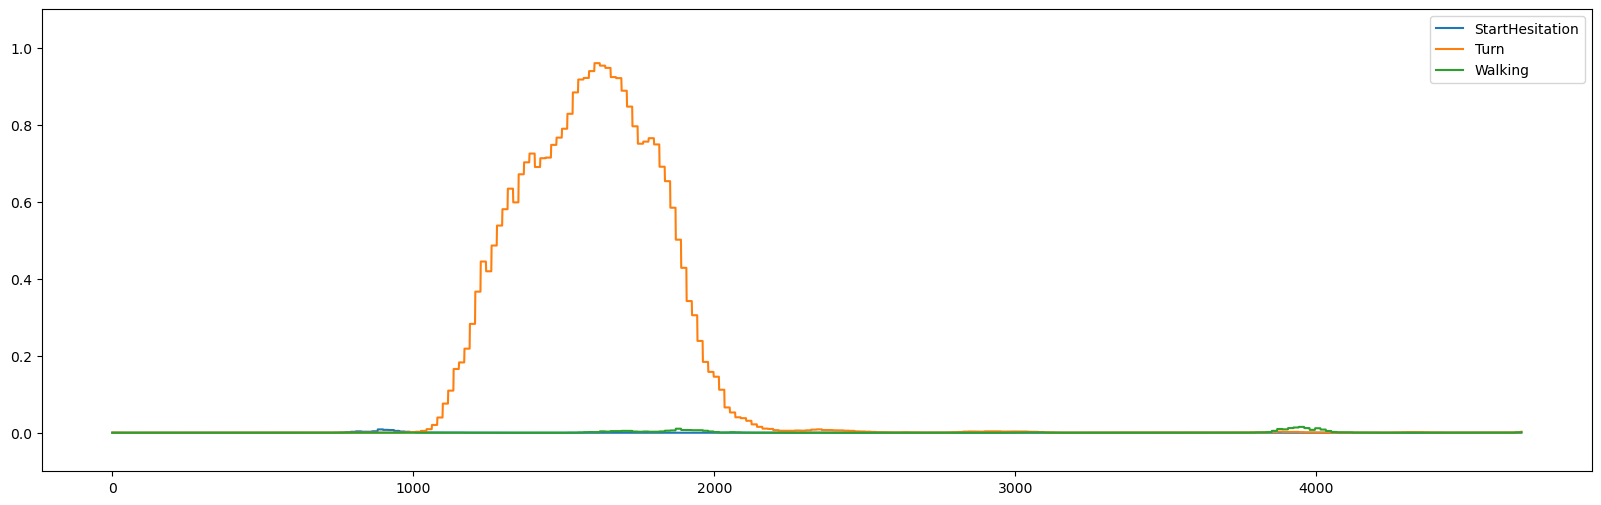

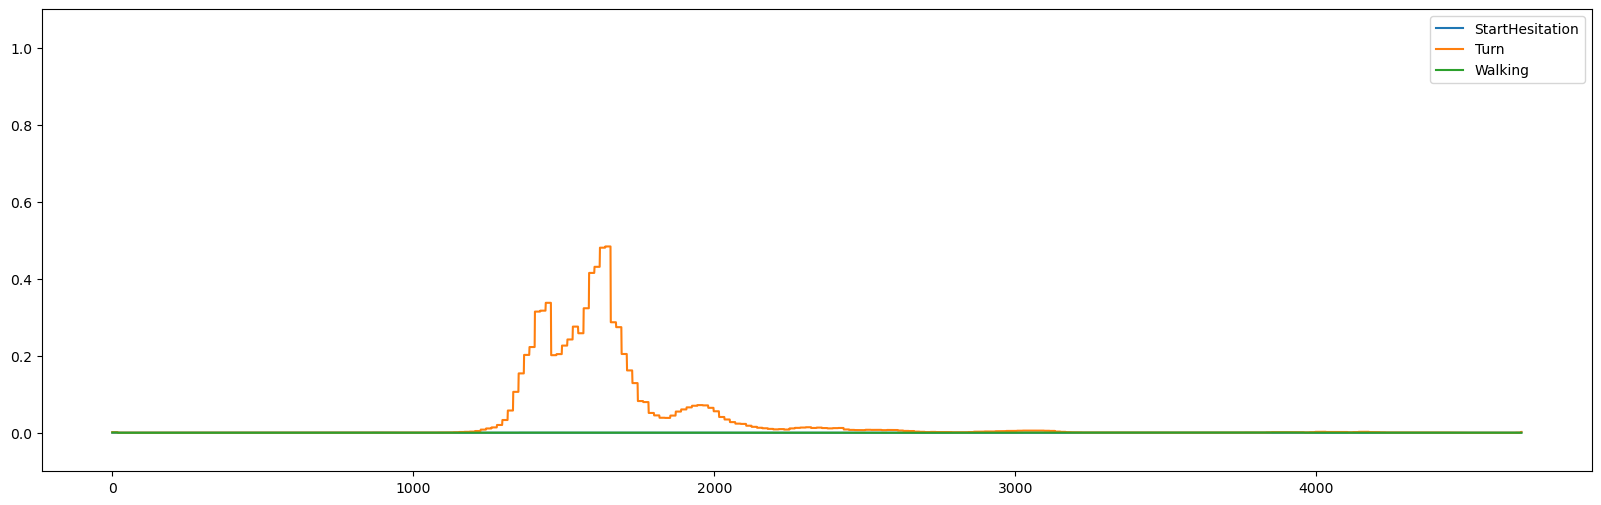

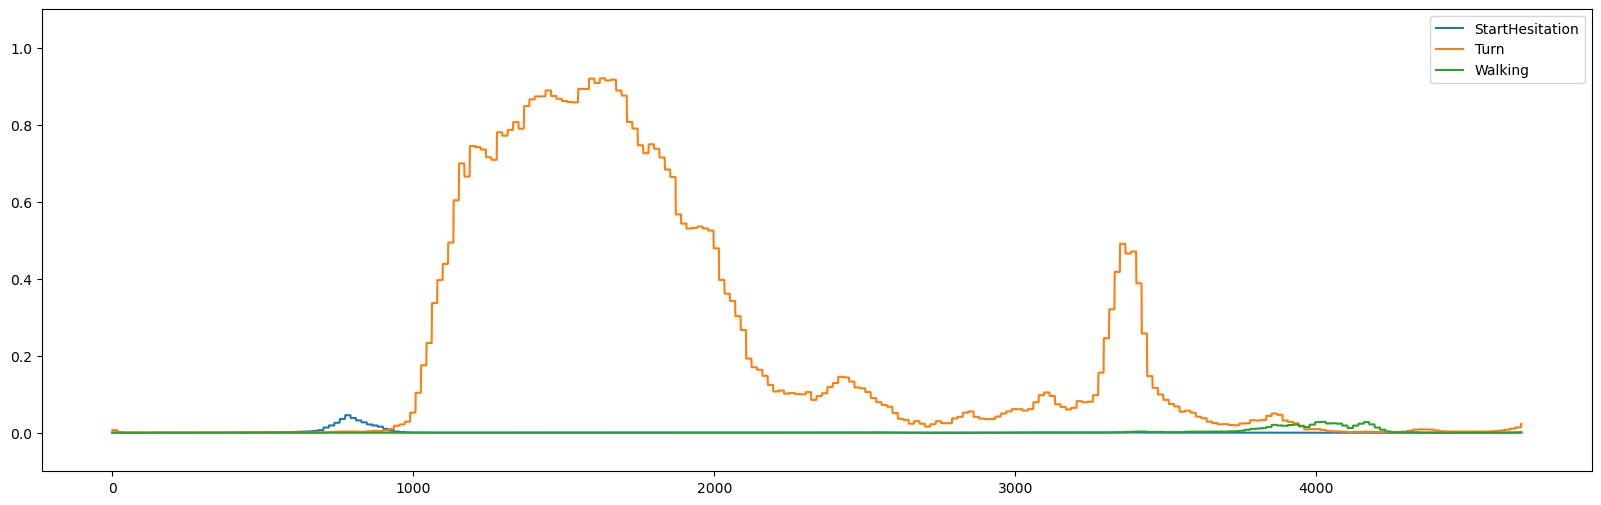

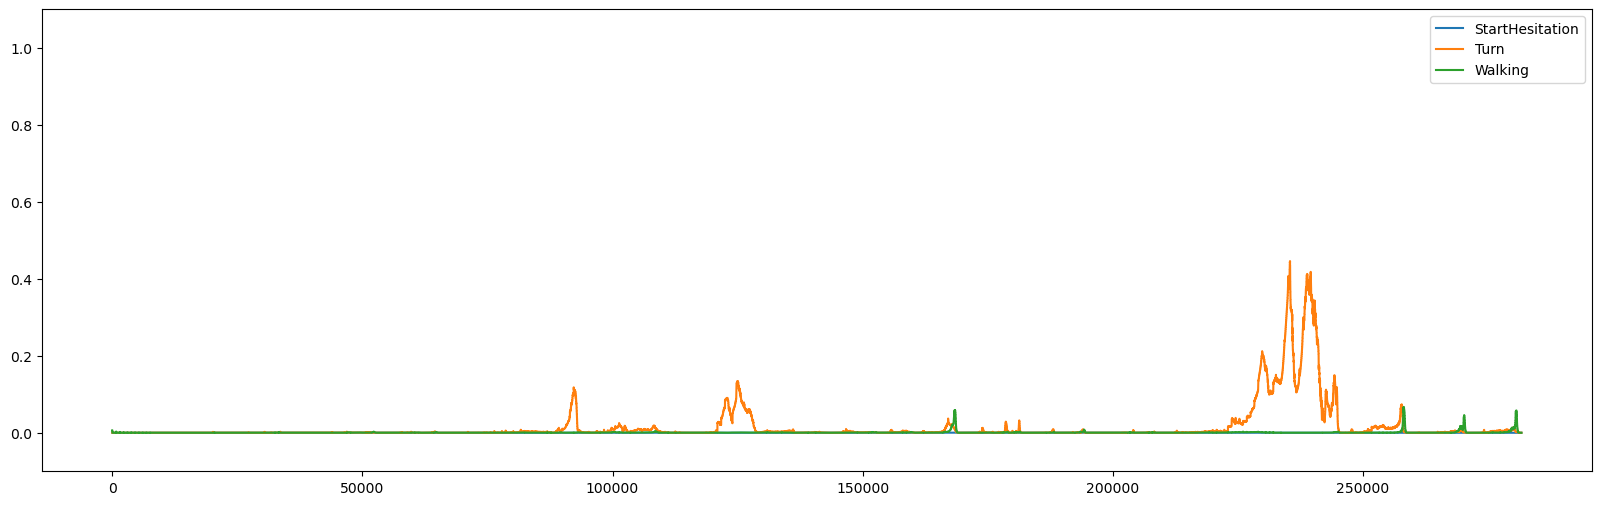

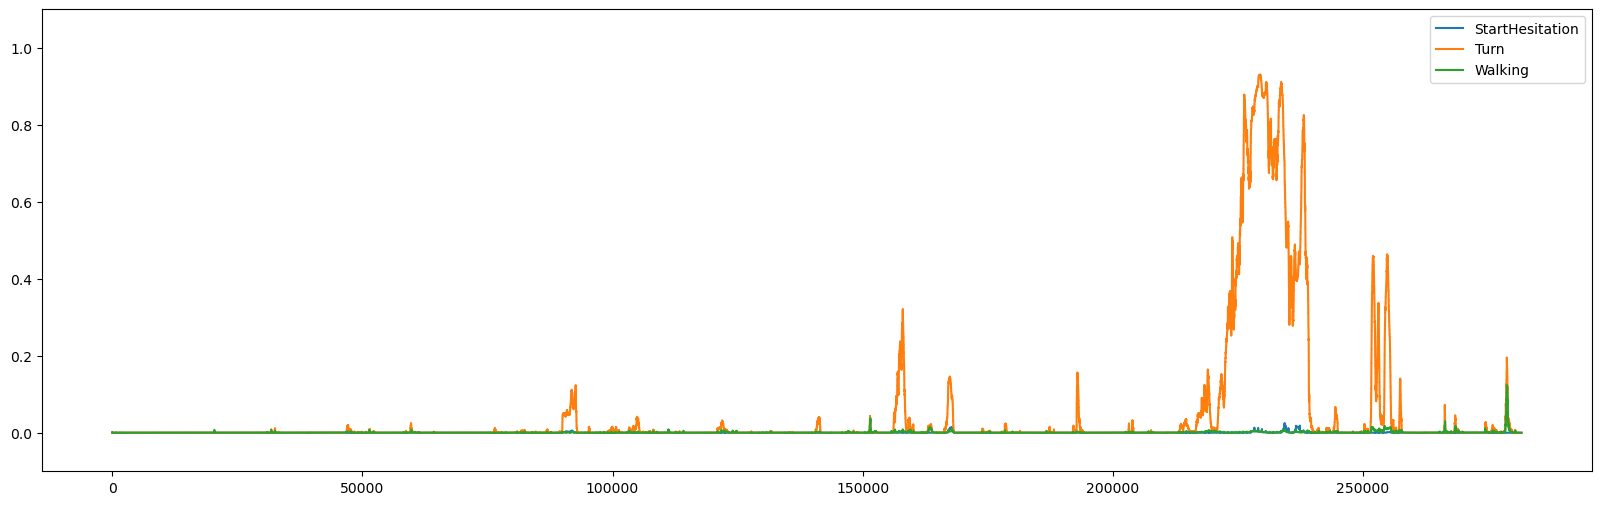

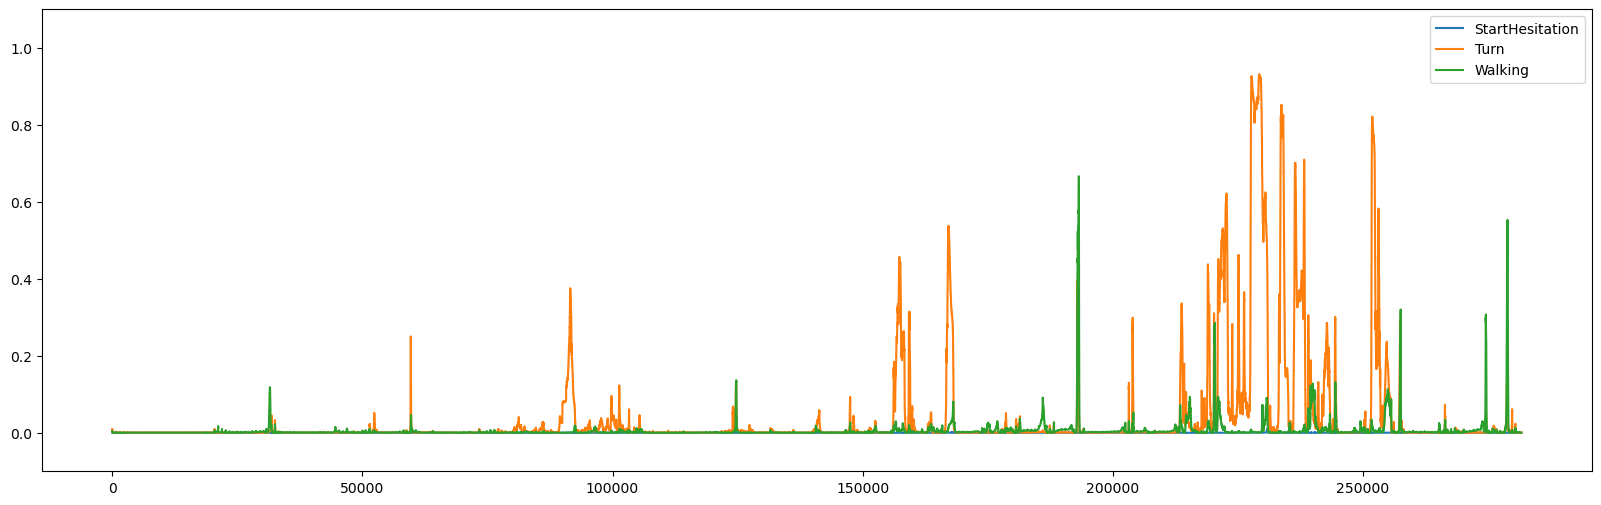

In [21]:
if len(all_submissions) <= 10:
    for series in all_submissions:
        plt.figure(figsize=(20, 6))
        plt.plot(series['StartHesitation'], label='StartHesitation')
        plt.plot(series['Turn'], label='Turn')
        plt.plot(series['Walking'], label='Walking')
        plt.ylim([-0.1, 1.1])
        plt.legend()
        plt.show()